In [1]:
# !pip install --upgrade pip
# !pip install --upgrade shap
# !pip install --upgrade pandas
# !pip install --upgrade tsfresh

In [2]:
### UNCOMMENT AND RUN THIS CELL FIRST IF RUNNING FROM GOOGLE COLAB
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [42]:
import os
working_directory = '/data/user/adam.ginza/misc/'
os.chdir(working_directory)

import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import datetime
from dateutil.relativedelta import relativedelta
import re
import pickle

from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.metrics import mean_squared_error

from statsmodels.stats.outliers_influence import variance_inflation_factor

import xgboost as xgb
import shap

from tsprial.forecasting import ForecastingCascade, ForecastingChain, ForecastingStacked, ForecastingRectified
from mapie.regression import MapieRegressor

from utils.general import load_yaml, iqr, get_distance_lat_lon
from utils.date_func import days_between
from utils.viz import create_count_amount_pareto
from utils.feature_engineering import add_lags, create_features

# LOAD CONFIG

In [3]:
configs = load_yaml('config/config.yaml')

In [4]:
configs

{'RAW_PATH': 'data/01.raw',
 'INTERMEDIATE_PATH': 'data/02.intermediate',
 'FINAL_PATH': 'data/03.final',
 'MODEL_PATH': 'data/04.models',
 'CUTOFF_DATE': datetime.date(2021, 11, 30),
 'PREDICTION_PATH': 'data/05.predictions'}

# 1. PREPARE DATA

### Read transactions

In [ ]:
trx = pd.read_csv(f'{configs["RAW_PATH"]}/transactions.csv')

#### Quick look on the trx data

No null rows in the transaction dataframe

In [ ]:
### get shape of dataframe and see first few rows
print(trx.shape)
trx.head()

(1582260, 5)


,id,user_id,store_id,event_occurrence,amount
0,a555eb55-1da4-6087-b5ab-06b35b608002,93098549-3ff0-e579-01c3-df9183278f64,a3c7874b-75df-9cf2-62ab-cf58be5d9e0e,2020-01-01 06:40:43.323987,315
1,f699b867-e70c-5160-90c8-7dfa32dce0da,35ba9da1-98d0-cbb7-7844-e648601b7208,1d59adf3-94f2-f5f8-46c6-8558c544a3a9,2020-01-01 07:04:25.968615,1646
2,5c3f8abc-f4e6-94fd-7b13-fe0efd4e4591,63cb5ee0-a457-9975-5455-4d76109bc754,c835f09d-ac5b-2005-1959-f452456a746a,2020-01-01 07:06:16.164563,385
3,f033da1a-bafb-5faa-67e3-c76b07b04333,786fcb82-40cf-1dc9-b9ba-2541502ca95a,eaf4c05d-13e1-7c8a-9ae0-cf2ec2e3dcd2,2020-01-01 07:07:26.029685,166
4,ccc35ffe-ee42-b696-783c-6670bfd800ec,acc814f5-beb6-db35-64f1-52f7c5a8466c,a8301ae2-df3b-ffe4-0279-c74af1dbb847,2020-01-01 07:12:24.448015,656


Since there's no assigned column names, we'll check on which column refers to which other dataset by joining later on.

In [ ]:
trx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1582260 entries, 0 to 1582259
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   id                1582260 non-null  object
 1   user_id           1582260 non-null  object
 2   store_id          1582260 non-null  object
 3   event_occurrence  1582260 non-null  object
 4   amount            1582260 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 60.4+ MB


No null rows in the transaction dataset. Will check if there's any literal string **NA** or blank space in any columns.

Need to convert the column **event_occurence** into datetime datatype.

In [ ]:
trx['event_occurrence'] = pd.to_datetime(trx['event_occurrence'])

Check again if column **event_occurrence** has been converted into a datetime datatype.

Since there was no error when converting the **event_occurrence** column, then it is safe to say there was no literal string that could make up a null value.

In [ ]:
trx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1582260 entries, 0 to 1582259
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   id                1582260 non-null  object        
 1   user_id           1582260 non-null  object        
 2   store_id          1582260 non-null  object        
 3   event_occurrence  1582260 non-null  datetime64[ns]
 4   amount            1582260 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 60.4+ MB


In [ ]:
trx.describe(include = 'all')

/tmp/ipykernel_4003/27448712.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  trx.describe(include = 'all')


,id,user_id,store_id,event_occurrence,amount
count,1582260,1582260,1582260,1582260,1.582260e+06
unique,1582260,9542,95460,1582259,NaN
top,6d243198-7ac7-4bbf-924f-e28276a158c8,ffbdfd47-dc79-72f0-1338-94b3854ca896,205a9fb1-7000-006a-853d-e97b7bdf8499,2021-03-08 10:59:53.518682,NaN
freq,1,478,1594,2,NaN
first,NaN,NaN,NaN,2020-01-01 06:40:43.323987,NaN
last,NaN,NaN,NaN,2021-12-31 17:09:49.237044,NaN
mean,NaN,NaN,NaN,NaN,1.703913e+03
std,NaN,NaN,NaN,NaN,5.361803e+03
min,NaN,NaN,NaN,NaN,2.000000e+00
25%,NaN,NaN,NaN,NaN,3.320000e+02


* Looks like there's an outlier in the column **amount** since the max is way off from the 75th percentile. Will do a treatment on the analysis and model building.
* Column **id** has the same number of count as well as the unique count. Hence, we can consider this as the unique transaction identifier.
* Only ONE simultaneous transactions happened in the exact same time.
* We can rename column **event_occurrence** to trx_time and column **amount** to trx_amount for now.
* We can create new column that contains the date taken from the **event_occurrence** column.

In [ ]:
trx.rename(columns = {'event_occurrence':'trx_datetime', 'amount':'trx_amount', 'id':'trx_id'}, inplace=True)

In [ ]:
## CONVERT DATETIME TO DATE AND STORE TO NEW COLUMN
trx['trx_date'] = pd.to_datetime(trx['trx_datetime']).dt.date

### Read users

In [ ]:
users = pd.read_csv(f"{configs['RAW_PATH']}/users.csv")

In [ ]:
users.head()

,id,gender,age
0,3cf2d95c-851a-3e66-bd62-36050c1aa8dd,M,30.0
1,a85536f3-1bf8-fbeb-d06e-62e6dc5a2a83,M,55.0
2,355a293c-2c15-d6bd-45ce-cd3c275ee5a9,M,40.0
3,61fb5b45-9bf8-1659-7a0c-b6f85a0f870b,NaN,NaN
4,ff9e16ef-3a0b-9373-567f-fb07cbc96874,M,90.0


In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9961 entries, 0 to 9960
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      9961 non-null   object 
 1   gender  8965 non-null   object 
 2   age     9463 non-null   float64
dtypes: float64(1), object(2)
memory usage: 233.6+ KB


In [ ]:
users.describe(include='all')

,id,gender,age
count,9961,8965,9463.000000
unique,9961,3,NaN
top,08055d83-2d81-b097-b80f-142f87bfef1a,M,NaN
freq,1,5352,NaN
mean,NaN,NaN,52.730318
std,NaN,NaN,21.441445
min,NaN,NaN,15.000000
25%,NaN,NaN,34.000000
50%,NaN,NaN,52.000000
75%,NaN,NaN,71.000000


**Takeaways:**
* No duplicate users
* Gender has 3 unique values. Will check if it makes sense.
* Max Age is at 90. Although it's still possible, we could look at the proportion of users who are above 75th percentile of Age.

#### Rename column for consistency

In [ ]:
users.rename(columns={'id': 'user_id'}, inplace=True)

#### Look at the null Gender and Age

In [ ]:
age_or_gender_null = users[(users['gender'].isna()) | (users['age'].isna())].shape[0] / users.shape[0]
gender_null = users[(users['gender'].isna())].shape[0] / users.shape[0]
age_null = users[(users['age'].isna())].shape[0] / users.shape[0]

print(f"""
Null age is {age_null:.2%}.
Null gender is {gender_null:.2%}.
Null gender or age is {age_or_gender_null:.2%}%.
""")


Null age is 5.00%.
Null gender is 10.00%.
Null gender or age is 10.00%%.



#### Check on unique values of Gender

In [ ]:
users['gender'].value_counts()

M        5352
F        3596
OTHER      17
Name: gender, dtype: int64

Gender looks okay!!!

#### Check potential outliers in Age column.

In [ ]:
check_age = users.loc[(~users['age'].isna()),['age']]

In [ ]:
age_Q1 = check_age['age'].quantile(0.25)
age_Q3 = check_age['age'].quantile(0.75)
age_IQR = age_Q3 - age_Q1
age_S = 1.5*age_IQR
age_LB = age_Q1 - age_S
age_UB = age_Q3 + age_S

check_age['above_UB'] = np.where(
    check_age['age'] > age_UB,
    1,
    0
)

In [ ]:
age_IQR, age_S, age_LB, age_UB

(37.0, 55.5, -21.5, 126.5)

In [ ]:
check_age['above_UB'].value_counts()

0    9463
Name: above_UB, dtype: int64

**Since there are no users with age exceed Upper Bound threshold of 126.5, this means that the age has no outliers. So, we don't do any special treatments to the age columns.**

### Read stores

In [ ]:
stores = pd.read_csv(f"{configs['RAW_PATH']}/stores.csv")

In [ ]:
stores.head()

,id,nam,laa,category,lat,lon
0,139a9a4b-1cb4-cb91-f718-d0bdd7db31c9,Aichi Ken,Agui Cho,ショッピング,34.951439,136.935126
1,437e0dae-dbf7-b1a8-4a03-010b9597bbd2,Aichi Ken,Agui Cho,マッサージ,34.947078,136.884972
2,2deb0ff0-5909-c169-4a23-4ed3979467fc,Aichi Ken,Agui Cho,その他,34.926083,136.928418
3,093585a3-96ce-7513-4d60-1dd36c4b30d2,Aichi Ken,Agui Cho,カフェ,34.952815,136.889037
4,d0637fde-e4c8-4c60-5817-a3494a623a6f,Aichi Ken,Agui Cho,グルメ,34.922963,136.892997


In [ ]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99991 entries, 0 to 99990
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        99991 non-null  object 
 1   nam       99991 non-null  object 
 2   laa       99991 non-null  object 
 3   category  99991 non-null  object 
 4   lat       99991 non-null  float64
 5   lon       99991 non-null  float64
dtypes: float64(2), object(4)
memory usage: 4.6+ MB


In [ ]:
stores['category'].value_counts()

その他               25860
ショッピング            18111
グルメ               14096
カフェ               11873
美容院・サロン            8987
ファッション             4999
ドラッグストア・薬局         3028
ホテル・旅館             2032
家電・携帯電話            2026
コンビニ               2026
ATMチャージ            1034
エンタメ               1006
病院・クリニック            996
スーパーマーケット           989
百貨店・ショッピングセンター      983
マッサージ               976
クリーニング              969
Name: category, dtype: int64

#### Rename Stores Columns

In [ ]:
stores.columns = ['store_id', 'nam', 'laa', 'category', 'lat', 'lon']

#### Get descriptive statistics on Store data

In [ ]:
stores.describe(include='all')

,store_id,nam,laa,category,lat,lon
count,99991,99991,99991,99991,99991.000000,99991.000000
unique,99991,47,1676,17,NaN,NaN
top,c408af8c-24e1-92df-2916-2fd063f10170,Tokyo To,Yokohama Shi,その他,NaN,NaN
freq,1,10273,2892,25860,NaN,NaN
mean,NaN,NaN,NaN,NaN,35.587883,137.092301
std,NaN,NaN,NaN,NaN,2.351620,3.428368
min,NaN,NaN,NaN,NaN,24.240666,122.988929
25%,NaN,NaN,NaN,NaN,34.676470,135.359701
50%,NaN,NaN,NaN,NaN,35.411915,138.090990
75%,NaN,NaN,NaN,NaN,35.916380,139.718822


Lat and Lon columns are looking fine since the max values are not shifted too much on the mean relative to the std deviation.

Since the **category** column is still in Japanese, we'll translate it into English for readability.

In [ ]:
# その他               25860
# ショッピング            18111
# グルメ               14096
# カフェ               11873
# 美容院・サロン            8987
# ファッション             4999
# ドラッグストア・薬局         3028
# ホテル・旅館             2032
# 家電・携帯電話            2026
# コンビニ               2026
# ATMチャージ            1034
# エンタメ               1006
# 病院・クリニック            996
# スーパーマーケット           989
# 百貨店・ショッピングセンター      983
# マッサージ               976
# クリーニング              969
store_category_map = {
    'コンビニ': 'conv store',
    'ショッピング': 'shopping',
    'グルメ': 'gourmet',
    'スーパーマーケット': 'supermarket',
    'カフェ': 'cafe',
    'その他': 'others',
    'ファッション': 'fashion',
    'ドラッグストア・薬局': 'pharmacy',
    'エンタメ': 'entertainment',
    'マッサージ': 'massage',
    '美容院・サロン': 'salon',
    '家電・携帯電話': 'home appliances',
    'ホテル・旅館': 'hotel',
    '病院・クリニック': 'hospital',
    'クリーニング': 'cleaning',
    '百貨店・ショッピングセンター': 'dept store',
    'ATMチャージ' : 'atm charge'
}

In [ ]:
stores['category_new'] = stores['category'].map(store_category_map)

In [ ]:
stores[stores['category_new'].isna()]

,store_id,nam,laa,category,lat,lon,category_new


In [ ]:
stores.drop('category', axis=1, inplace = True)
stores.rename(columns = {'category_new': 'category'}, inplace = True)

In [ ]:
stores.head()

,store_id,nam,laa,lat,lon,category
0,139a9a4b-1cb4-cb91-f718-d0bdd7db31c9,Aichi Ken,Agui Cho,34.951439,136.935126,shopping
1,437e0dae-dbf7-b1a8-4a03-010b9597bbd2,Aichi Ken,Agui Cho,34.947078,136.884972,massage
2,2deb0ff0-5909-c169-4a23-4ed3979467fc,Aichi Ken,Agui Cho,34.926083,136.928418,others
3,093585a3-96ce-7513-4d60-1dd36c4b30d2,Aichi Ken,Agui Cho,34.952815,136.889037,cafe
4,d0637fde-e4c8-4c60-5817-a3494a623a6f,Aichi Ken,Agui Cho,34.922963,136.892997,gourmet


### Checking on data completeness

#### Join trx with users

In [ ]:
print(f"""
# of Rows Before join trx dataframe with users: {trx.shape[0]}
# of Rows After join trx dataframe with users: {trx.merge(users,how = 'inner',left_on = 'user_id',right_on = 'user_id').shape[0]}
""")


# of Rows Before join trx dataframe with users: 1582260
# of Rows After join trx dataframe with users: 1582260



Because the number before and after the join is the same, we can conclude that <u>**user_id in trx**</u> has corresponding <u>**user_id in users**</u> table

#### Join trx with Stores

In [ ]:
print(f"""
# of Rows Before join trx dataframe with users: {trx.shape[0]}
# of Rows After join trx dataframe with users: {trx.merge(stores,how = 'inner',left_on = 'store_id',right_on = 'store_id').shape[0]}
""")


# of Rows Before join trx dataframe with users: 1582260
# of Rows After join trx dataframe with users: 1582260



Same with users table, <u>**store_id in trx**</u> has corresponding <u>**store_id in stores**</u> table

### Merge all tables to one Final table

In [ ]:
trx_fin = trx.merge(
    users,
    how = 'inner',
    left_on = 'user_id',
    right_on = 'user_id'
).merge(
    stores,
    how = 'inner',
    left_on = 'store_id',
    right_on = 'store_id'
)

In [ ]:
trx_fin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1582260 entries, 0 to 1582259
Data columns (total 13 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   trx_id        1582260 non-null  object        
 1   user_id       1582260 non-null  object        
 2   store_id      1582260 non-null  object        
 3   trx_datetime  1582260 non-null  datetime64[ns]
 4   trx_amount    1582260 non-null  int64         
 5   trx_date      1582260 non-null  object        
 6   gender        1421978 non-null  object        
 7   age           1505614 non-null  float64       
 8   nam           1582260 non-null  object        
 9   laa           1582260 non-null  object        
 10  lat           1582260 non-null  float64       
 11  lon           1582260 non-null  float64       
 12  category      1582260 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(8)
memory usage: 169.0+ MB


# 2. Handling Null values for Age and Gender

In [ ]:
## get # of rows with missing Age
trx_fin[trx_fin['age'].isna()].shape[0]

76646

In [ ]:
## get # of rows with missing Gender
trx_fin[trx_fin['gender'].isna()].shape[0]

160282

Before we choose to either drop the null rows or impute the columns, we need to look at the distribution first. If the distribution of the data differs significantly by removing the rows, then we could choose to impute the columns. 

#### Visualize the distribution of the **trx_amount**

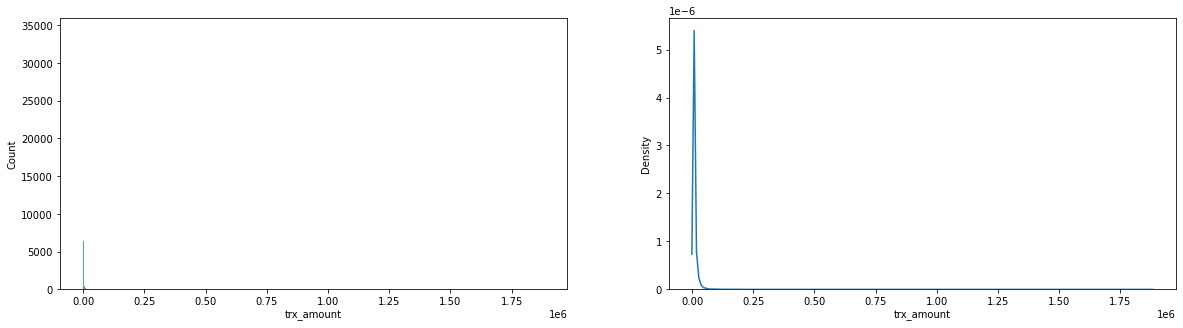

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

sns.histplot(x='trx_amount', data=trx_fin, ax = ax[0])
sns.kdeplot(x='trx_amount', data=trx_fin, ax = ax[1])
plt.show()

We can't see much of the distribution because the trx_amount is highly right skewed due to outliers in the column. Therefore, we need to convert **trx_amount** to logarithmic value.

By converting to **Logs**, there won't be a vast distance between values like in the original value.

In [ ]:
## Create a column with the log of trx_amount
trx_fin['trx_amount_log'] = np.log(trx_fin['trx_amount'])

In [ ]:
trx_fin.head()

,trx_id,user_id,store_id,trx_datetime,trx_amount,trx_date,gender,age,nam,laa,lat,lon,category,trx_amount_log
0,a555eb55-1da4-6087-b5ab-06b35b608002,93098549-3ff0-e579-01c3-df9183278f64,a3c7874b-75df-9cf2-62ab-cf58be5d9e0e,2020-01-01 06:40:43.323987,315,2020-01-01,M,88.0,Saitama Ken,Soka Shi,35.830649,139.809781,conv store,5.752573
1,5c3d2349-481f-1c77-a887-76be83e023d7,93098549-3ff0-e579-01c3-df9183278f64,a3c7874b-75df-9cf2-62ab-cf58be5d9e0e,2020-07-27 09:40:51.440810,219,2020-07-27,M,88.0,Saitama Ken,Soka Shi,35.830649,139.809781,conv store,5.389072
2,502bcb78-287a-fadf-390e-38d6244737ae,1f8a8d4e-dec8-e4da-7c8e-901e84151b73,a3c7874b-75df-9cf2-62ab-cf58be5d9e0e,2020-02-25 11:15:27.237772,193,2020-02-25,F,59.0,Saitama Ken,Soka Shi,35.830649,139.809781,conv store,5.262690
3,0e96330f-d581-9270-fec5-ced105081bea,1f8a8d4e-dec8-e4da-7c8e-901e84151b73,a3c7874b-75df-9cf2-62ab-cf58be5d9e0e,2020-04-22 12:20:33.925248,678,2020-04-22,F,59.0,Saitama Ken,Soka Shi,35.830649,139.809781,conv store,6.519147
4,23265b10-4398-90b1-cdbc-c2c38a570774,1f8a8d4e-dec8-e4da-7c8e-901e84151b73,a3c7874b-75df-9cf2-62ab-cf58be5d9e0e,2021-04-02 11:47:18.325738,964,2021-04-02,F,59.0,Saitama Ken,Soka Shi,35.830649,139.809781,conv store,6.871091


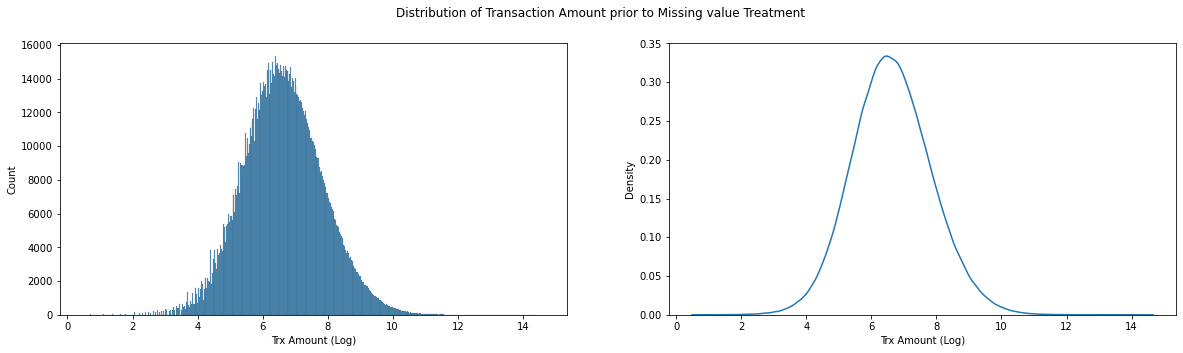

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(20,5), sharex=True)

sns.histplot(x='trx_amount_log', data=trx_fin, ax = axes[0])
sns.kdeplot(x='trx_amount_log', data=trx_fin, ax = axes[1])
plt.suptitle('Distribution of Transaction Amount prior to Missing value Treatment')
axes[0].set_xlabel('Trx Amount (Log)')
axes[1].set_xlabel('Trx Amount (Log)')
plt.show()

#### DELETE Rows with Null Age or Gender Columns

In [ ]:
trx_fin_del = trx_fin[(~trx_fin['age'].isna()) & (~trx_fin['gender'].isna())]

In [ ]:
print(f"""
Before row deletion: {trx_fin.shape[0]} Rows.
After row deletion: {trx_fin_del.shape[0]} Rows.
Reduction of: {(trx_fin_del.shape[0] / trx_fin.shape[0])-1:.2%}
""")


Before row deletion: 1582260 Rows.
After row deletion: 1421978 Rows.
Reduction of: -10.13%



Checking the distribution after deletion

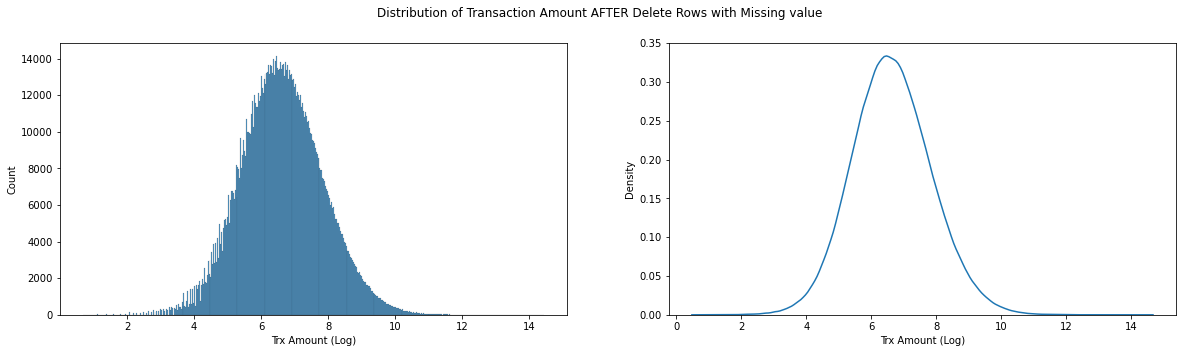

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(20,5))

sns.histplot(x='trx_amount_log', data=trx_fin_del, ax = axes[0])
sns.kdeplot(x='trx_amount_log', data=trx_fin_del, ax = axes[1])
plt.suptitle('Distribution of Transaction Amount AFTER Delete Rows with Missing value')
axes[0].set_xlabel('Trx Amount (Log)')
axes[1].set_xlabel('Trx Amount (Log)')
plt.show()

**Conclusion**: Since the reduction after deletion is only 10%, and after the deletion there was no significant difference in distribution of the Transaction Amount, we can continue the analysis by removing rows with missing Gender and Age values.

#### Save the cleaned and raw dataframe to csv

In [ ]:
trx_fin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1582260 entries, 0 to 1582259
Data columns (total 14 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   trx_id          1582260 non-null  object        
 1   user_id         1582260 non-null  object        
 2   store_id        1582260 non-null  object        
 3   trx_datetime    1582260 non-null  datetime64[ns]
 4   trx_amount      1582260 non-null  int64         
 5   trx_date        1582260 non-null  object        
 6   gender          1421978 non-null  object        
 7   age             1505614 non-null  float64       
 8   nam             1582260 non-null  object        
 9   laa             1582260 non-null  object        
 10  lat             1582260 non-null  float64       
 11  lon             1582260 non-null  float64       
 12  category        1582260 non-null  object        
 13  trx_amount_log  1582260 non-null  float64       
dtypes: datetime64[ns](

In [ ]:
trx_fin_del.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1421978 entries, 0 to 1582259
Data columns (total 14 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   trx_id          1421978 non-null  object        
 1   user_id         1421978 non-null  object        
 2   store_id        1421978 non-null  object        
 3   trx_datetime    1421978 non-null  datetime64[ns]
 4   trx_amount      1421978 non-null  int64         
 5   trx_date        1421978 non-null  object        
 6   gender          1421978 non-null  object        
 7   age             1421978 non-null  float64       
 8   nam             1421978 non-null  object        
 9   laa             1421978 non-null  object        
 10  lat             1421978 non-null  float64       
 11  lon             1421978 non-null  float64       
 12  category        1421978 non-null  object        
 13  trx_amount_log  1421978 non-null  float64       
dtypes: datetime64[ns](

In [ ]:
trx_fin_del.drop(
    'trx_amount_log', 
    axis = 1
).to_csv(
    f"{configs['INTERMEDIATE_PATH']}/trx_clean.csv", index=False
)

In [ ]:
trx_fin.drop(
    'trx_amount_log', 
    axis = 1
).to_csv(
    f"{configs['INTERMEDIATE_PATH']}/trx_fin_raw.csv", index=False
)

# 3. Exploratory Data Analysis

In [ ]:
trx_fin = pd.read_csv(f"{configs['INTERMEDIATE_PATH']}/trx_clean.csv")

In [ ]:
trx_fin.head()

,trx_id,user_id,store_id,trx_datetime,trx_amount,trx_date,gender,age,nam,laa,lat,lon,category
0,a555eb55-1da4-6087-b5ab-06b35b608002,93098549-3ff0-e579-01c3-df9183278f64,a3c7874b-75df-9cf2-62ab-cf58be5d9e0e,2020-01-01 06:40:43.323987,315,2020-01-01,M,88.0,Saitama Ken,Soka Shi,35.830649,139.809781,conv store
1,5c3d2349-481f-1c77-a887-76be83e023d7,93098549-3ff0-e579-01c3-df9183278f64,a3c7874b-75df-9cf2-62ab-cf58be5d9e0e,2020-07-27 09:40:51.440810,219,2020-07-27,M,88.0,Saitama Ken,Soka Shi,35.830649,139.809781,conv store
2,502bcb78-287a-fadf-390e-38d6244737ae,1f8a8d4e-dec8-e4da-7c8e-901e84151b73,a3c7874b-75df-9cf2-62ab-cf58be5d9e0e,2020-02-25 11:15:27.237772,193,2020-02-25,F,59.0,Saitama Ken,Soka Shi,35.830649,139.809781,conv store
3,0e96330f-d581-9270-fec5-ced105081bea,1f8a8d4e-dec8-e4da-7c8e-901e84151b73,a3c7874b-75df-9cf2-62ab-cf58be5d9e0e,2020-04-22 12:20:33.925248,678,2020-04-22,F,59.0,Saitama Ken,Soka Shi,35.830649,139.809781,conv store
4,23265b10-4398-90b1-cdbc-c2c38a570774,1f8a8d4e-dec8-e4da-7c8e-901e84151b73,a3c7874b-75df-9cf2-62ab-cf58be5d9e0e,2021-04-02 11:47:18.325738,964,2021-04-02,F,59.0,Saitama Ken,Soka Shi,35.830649,139.809781,conv store


In [ ]:
trx_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1421978 entries, 0 to 1421977
Data columns (total 13 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   trx_id        1421978 non-null  object 
 1   user_id       1421978 non-null  object 
 2   store_id      1421978 non-null  object 
 3   trx_datetime  1421978 non-null  object 
 4   trx_amount    1421978 non-null  int64  
 5   trx_date      1421978 non-null  object 
 6   gender        1421978 non-null  object 
 7   age           1421978 non-null  float64
 8   nam           1421978 non-null  object 
 9   laa           1421978 non-null  object 
 10  lat           1421978 non-null  float64
 11  lon           1421978 non-null  float64
 12  category      1421978 non-null  object 
dtypes: float64(3), int64(1), object(9)
memory usage: 141.0+ MB


### 3.1 Pareto Analysis

In [ ]:
trx_fin['age'].describe()

count    1.421978e+06
mean     5.000995e+01
std      1.910857e+01
min      1.500000e+01
25%      3.400000e+01
50%      4.900000e+01
75%      6.500000e+01
max      9.000000e+01
Name: age, dtype: float64

In [ ]:
### Create age group
"""
children 0-12
teenager 13-19
young adults 20-30
middle aged 31-45
old adults >45
"""

trx_fin['age_group'] = pd.cut(
    x=trx_fin['age'], 
    bins=[0, 12, 19, 30, 45, float("inf")],
    labels=['children',
            'teenager',
            'young adults',
            'middle aged',
            'old adults'])


In [ ]:
trx_fin['age_group'].value_counts(normalize=True)

old adults      0.560402
middle aged     0.252133
young adults    0.148642
teenager        0.038823
children        0.000000
Name: age_group, dtype: float64

In [ ]:
trx_agg_age = trx_fin.groupby(
    ['age_group'],
    as_index = False,
    observed = True
).agg(
    count=('trx_amount', 'size'),
    tot_daily_amount = ('trx_amount', 'sum')
    )

trx_agg_age = trx_agg_age.sort_values('tot_daily_amount', ascending=False)
trx_agg_age['cum_pct_trx_amount'] = round(trx_agg_age['tot_daily_amount'].cumsum() / trx_agg_age['tot_daily_amount'].sum() * 100, 2)
trx_agg_age['cum_pct_trx_count'] = round(trx_agg_age['count'].cumsum() / trx_agg_age['count'].sum() * 100, 2)

In [ ]:
trx_agg_age

,age_group,count,tot_daily_amount,cum_pct_trx_amount,cum_pct_trx_count
3,old adults,796880,1362943368,56.24,56.04
2,middle aged,358527,610302716,81.42,81.25
1,young adults,211366,356819241,96.14,96.12
0,teenager,55205,93557675,100.00,100.00


In [ ]:
# def create_count_amount_pareto(df_raw, 
#                                group_col, 
#                                xlabel=None,
#                                return_agg_df = False
#                               ):
#     """Function to create pareto analysis on specific group of transaction
#     :df_raw: Raw dataframe before aggregated
#     :group_col: Columm which is used as the x-axis of the analysis
#     :count_col: Column that contains count of trx
#     :amount_col: Column that contains amount of trx
#     """
    
#     ### CREATE DATA AGGREGATION ###
#     df = df_raw.groupby(
#         [group_col],
#         as_index = False,
#         observed = True
#     ).agg(
#         count=('trx_amount', 'size'),
#         tot_daily_amount = ('trx_amount', 'sum')
#         )

#     df = df.sort_values('tot_daily_amount', ascending=False)
#     df['cum_pct_trx_amount'] = round(df['tot_daily_amount'].cumsum() / df['tot_daily_amount'].sum() * 100, 2)
# #     df['cum_pct_trx_count'] = round(df['count'].cumsum() / df['count'].sum() * 100, 2)
    
#     #### START CREATING CHART ####
#     fig = plt.figure(figsize=(20,5))

#     ### FIRST CHART
#     ax = fig.add_subplot(121)
#     # Plot bars (i.e. frequencies)
#     ax.bar(df[group_col], df['tot_daily_amount'])
#     ax.set_title(f"{xlabel} by Total Transaction Amount") 
#     ax.set_xlabel(xlabel)
#     ax.set_ylabel("Total Trx Amount");

#     # Second y axis (i.e. cumulative percentage)
#     ax2 = ax.twinx()
#     ax2.plot(df[group_col], df['cum_pct_trx_amount'], color="red", marker="D", ms=7)
#     ax2.axhline(80, color="orange", linestyle="dashed")
#     ax2.yaxis.set_major_formatter(PercentFormatter());

#     ### SECOND CHART
    
#     df = df.sort_values('count', ascending=False)
# #     df['cum_pct_trx_amount'] = round(df['tot_daily_amount'].cumsum() / df['tot_daily_amount'].sum() * 100, 2)
#     df['cum_pct_trx_count'] = round(df['count'].cumsum() / df['count'].sum() * 100, 2)
    
#     ax_1 = fig.add_subplot(122)
#     # Plot bars (i.e. frequencies)
#     ax_1.bar(df[group_col], df['count'])
#     ax_1.set_title(f"{xlabel} by Total Transaction Count") # 
#     ax_1.set_xlabel(xlabel) # "Age Group"
#     ax_1.set_ylabel("Total Trx Count");

#     # Second y axis (i.e. cumulative percentage)
#     ax_12 = ax_1.twinx()
#     ax_12.plot(df[group_col], df['cum_pct_trx_count'], color="red", marker="D", ms=7)
#     ax_12.axhline(80, color="orange", linestyle="dashed")
#     ax_12.yaxis.set_major_formatter(PercentFormatter())
#     ax_12.set_ylabel("Cumulative Percentage");
    
#     ## Rotate xlabel
#     ax.tick_params(axis='x', labelrotation = 45)
#     ax_1.tick_params(axis='x', labelrotation = 45)
    
#     if return_agg_df:
#         return df

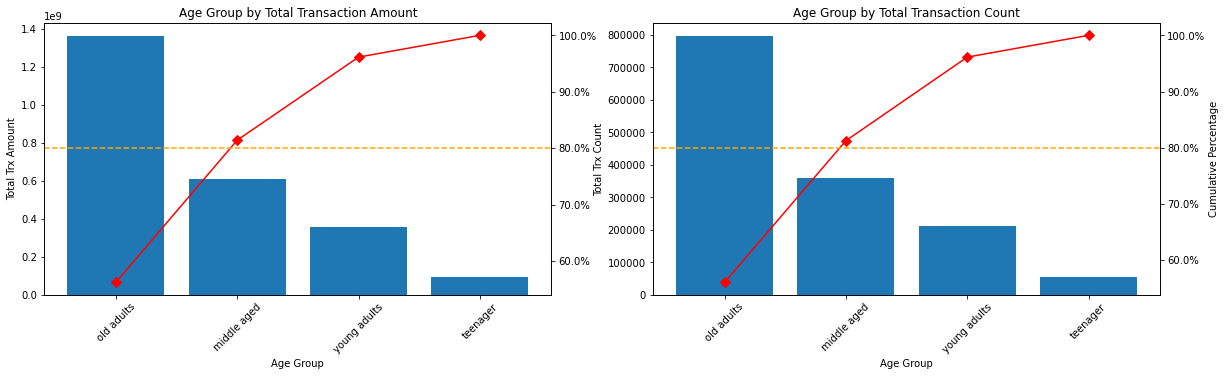

In [ ]:
trx_age_agg = create_count_amount_pareto(
    trx_fin, 
    'age_group', 
    xlabel = 'Age Group',
    return_agg_df = True
)

In [ ]:
trx_age_agg

,age_group,count,tot_daily_amount,cum_pct_trx_amount,cum_pct_trx_count
3,old adults,796880,1362943368,56.24,56.04
2,middle aged,358527,610302716,81.42,81.25
1,young adults,211366,356819241,96.14,96.12
0,teenager,55205,93557675,100.00,100.00


**Takeaways:**
* From the above analysis, it can be seen that old-adults and middle-aged age groups covered **80%** of both Total Transaction Amount and Total Transaction Count
* This means if there are any campaigns that will be run in the near future, targeting these two groups of people will have a great impact to the total GMV for a period of time.
* We can use this analysis not only to selectively target promos for specific group of people, but also can be used to revamp the UI/UX of the app to accomodate functionalities that suit with middle-aged and old-adult users.

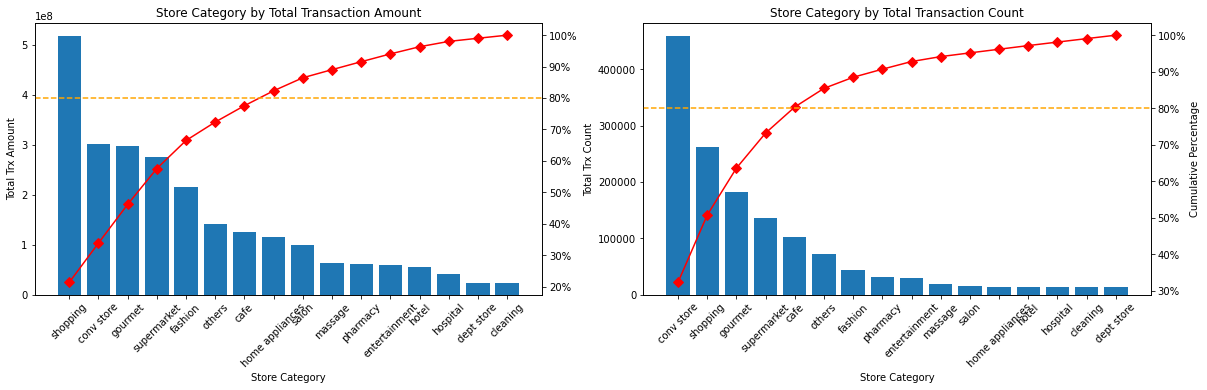

In [ ]:
trx_name_agg = create_count_amount_pareto(
    trx_fin, 
    'category', 
    xlabel = 'Store Category',
    return_agg_df = True
)

In [ ]:
trx_name_agg.head()

,category,count,tot_daily_amount,cum_pct_trx_amount,cum_pct_trx_count
2,conv store,459499,302658571,33.89,32.31
14,shopping,261662,518601657,21.40,50.72
6,gourmet,182939,298307811,46.19,63.58
15,supermarket,136672,276269334,57.59,73.19
0,cafe,101535,126098954,77.57,80.33


**Takeaways**:
* Unlike age column, Store Category have different store category focus for different Business Metrics
* If we want to increase **GMV Amount**, we could focus to apply marketing campaigns on these following store categories because they cover more than 80% of total **GMV Amount**:
    * Shopping
    * Convenience Store
    * Gourmet
    * Supermarket
    * Fashion
    * Others
    * Cafe
    * Home Appliances
* If we want to increase **Transaction Count**, we could focus to apply marketing campaigns on these store categories because of the same reason:
    * Convenience Store
    * Shopping
    * Gourmet
    * Supermarket
    * Cafe

### 3.2 Churn Analysis

In [ ]:
### Get the avg and median of total daily trx_amount per user
trx_agg_user = trx_fin.groupby(
    ['user_id', 'trx_date'],
    as_index = False,
    observed = True
).agg(
    count = ('trx_amount', 'size'),
    tot_daily_trx_amount = ('trx_amount', 'sum')
).groupby(
    ['user_id'],
    as_index = False,
    observed = True
).agg(
    total_trx_count = ('count', 'sum'),
    total_trx_days = ('trx_date', 'size'),
    tot_trx_amount = ('tot_daily_trx_amount', 'sum'),
    avg_daily_trx_amount = ('tot_daily_trx_amount', 'mean'),
    median_daily_trx_amount = ('tot_daily_trx_amount', 'median')
)

trx_agg_user['avg_trx_per_day'] = trx_agg_user['total_trx_count'] / trx_agg_user['total_trx_days']

## avg trx per day norm = total number of transactions /  days difference between min trx_date and max trx_date
trx_agg_user['avg_trx_per_day_norm'] = trx_agg_user['total_trx_count'] / days_between(trx_fin['trx_date'].min(), trx_fin['trx_date'].max())

## Active days norm = total number of transaction days /  days difference between min trx_date and max trx_date
trx_agg_user['active_days_norm'] = trx_agg_user['total_trx_days'] / days_between(trx_fin['trx_date'].min(), trx_fin['trx_date'].max())

## Churn days = 1 - Active days norm
trx_agg_user['churn_days'] = 1 - trx_agg_user['active_days_norm']
trx_agg_user.describe()

,total_trx_count,total_trx_days,tot_trx_amount,avg_daily_trx_amount,median_daily_trx_amount,avg_trx_per_day,avg_trx_per_day_norm,active_days_norm,churn_days
count,8587.000000,8587.000000,8.587000e+03,8587.000000,8587.000000,8587.000000,8587.000000,8587.000000,8587.000000
mean,165.596600,134.760801,2.822433e+05,2071.963880,969.563526,1.215075,0.226845,0.184604,0.815396
std,117.676062,92.734566,2.241938e+05,964.208586,377.112774,0.097870,0.161200,0.127034,0.127034
min,1.000000,1.000000,6.900000e+01,69.000000,69.000000,1.000000,0.001370,0.001370,0.523288
25%,63.000000,52.000000,9.803400e+04,1554.372215,738.500000,1.156863,0.086301,0.071233,0.712329
50%,147.000000,122.000000,2.382710e+05,1956.437209,924.500000,1.210526,0.201370,0.167123,0.832877
75%,252.000000,210.000000,4.219095e+05,2423.714286,1133.000000,1.269962,0.345205,0.287671,0.928767
max,469.000000,348.000000,2.178767e+06,32379.600000,7115.000000,3.000000,0.642466,0.476712,0.998630


In [ ]:
trx_agg_user.head()

,user_id,total_trx_count,total_trx_days,tot_trx_amount,avg_daily_trx_amount,median_daily_trx_amount,avg_trx_per_day,avg_trx_per_day_norm,active_days_norm,churn_days
0,00073cc2-c801-c67c-d039-fca63c78c6a9,112,98,205948,2101.510204,953.0,1.142857,0.153425,0.134247,0.865753
1,000b6710-f8b4-ddd4-1913-90c7d424fccf,183,154,289285,1878.474026,1214.0,1.188312,0.250685,0.210959,0.789041
2,00183cfe-ceb0-9220-7984-f33f61c61ae4,374,295,789955,2677.813559,1302.0,1.267797,0.512329,0.404110,0.595890
3,001b10c4-0ec1-68c9-a059-0a44159119bd,203,182,436061,2395.939560,920.5,1.115385,0.278082,0.249315,0.750685
4,0021b632-3246-b7d9-bb29-66398e4a295d,217,167,343692,2058.035928,1189.0,1.299401,0.297260,0.228767,0.771233


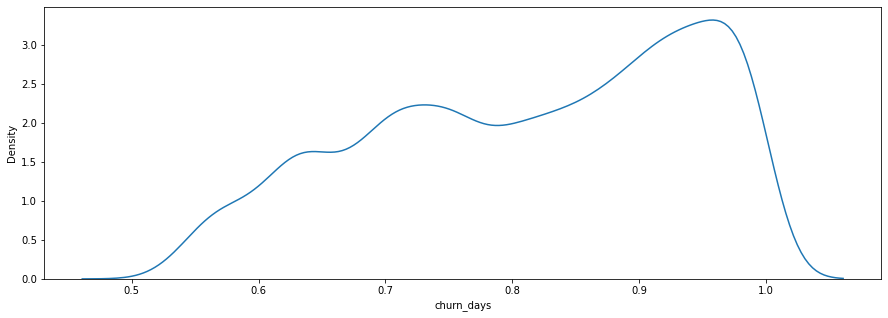

In [ ]:
fig = plt.figure(figsize=(15,5))

sns.kdeplot(x=trx_agg_user['churn_days'], data = trx_agg_user)
plt.show()

In [ ]:
### Create active days group
"""

"""
bins, labels = pd.cut(
    x=trx_agg_user['churn_days'], 
    bins=[-float("inf"), 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, float("inf")],
    retbins=True)

trx_agg_user['churn_days_group'] = bins

In [ ]:
median_churn_days = trx_agg_user.groupby(
    'churn_days_group',
    as_index = False,
    observed = True
).agg(
    total_users = ('user_id', 'size'),
    median_trx_amount = ('median_daily_trx_amount', 'median'),
    median_trx_count = ('total_trx_count', 'median')
)
median_churn_days['pct_users'] = median_churn_days['total_users'] / median_churn_days['total_users'].sum() * 100
median_churn_days['pct_users_cum_sum'] = median_churn_days['pct_users'].cumsum()

In [ ]:
median_churn_days

,churn_days_group,total_users,median_trx_amount,median_trx_count,pct_users,pct_users_cum_sum
0,"(0.5, 0.55]",78,1032.50,438.5,0.908350,0.908350
1,"(0.55, 0.6]",407,1035.00,406.0,4.739723,5.648073
2,"(0.6, 0.65]",698,957.75,341.0,8.128566,13.776639
3,"(0.65, 0.7]",703,927.00,287.0,8.186794,21.963433
4,"(0.7, 0.75]",978,907.50,241.0,11.389309,33.352743
5,"(0.75, 0.8]",858,927.00,198.0,9.991848,43.344591
6,"(0.8, 0.85]",892,914.50,154.0,10.387796,53.732386
7,"(0.85, 0.9]",1091,912.50,108.0,12.705252,66.437638
8,"(0.9, 0.95]",1358,905.00,65.0,15.814603,82.252242
9,"(0.95, inf]",1524,910.25,20.0,17.747758,100.000000


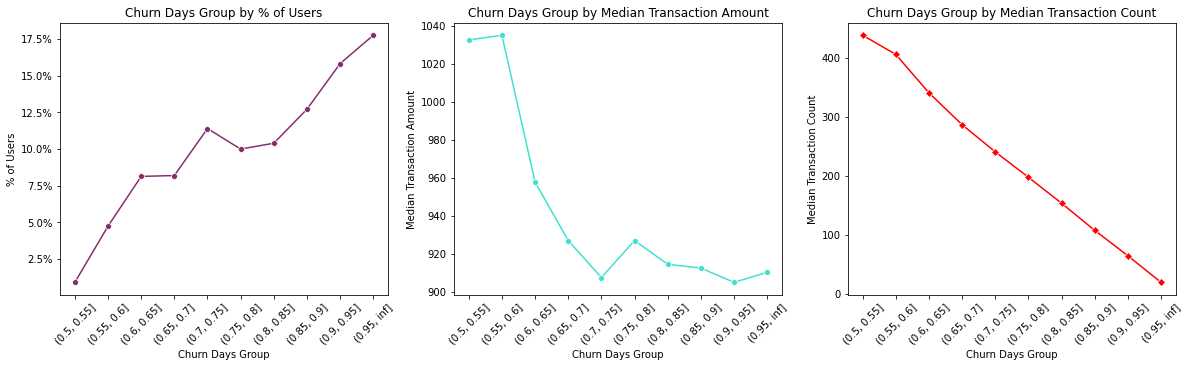

In [ ]:
fig, axes = plt.subplots(1,3, figsize = (20,5))

ax2 = sns.lineplot(x=median_churn_days['churn_days_group'].astype(str), y=median_churn_days['pct_users'], ax=axes[0], color='#842E6C', marker = "o")
ax2.tick_params(axis='x', labelrotation = 45)
ax2.set_xlabel('Churn Days Group')
ax2.set_ylabel('% of Users')
ax2.set_title('Churn Days Group by % of Users')
ax2.yaxis.set_major_formatter(PercentFormatter())

ax = sns.lineplot(x=median_churn_days['churn_days_group'].astype(str), y=median_churn_days['median_trx_amount'], ax=axes[1], color='#40E0D0', marker = "o")
ax.tick_params(axis='x', labelrotation = 45)
ax.set_xlabel('Churn Days Group')
ax.set_ylabel('Median Transaction Amount')
ax.set_title('Churn Days Group by Median Transaction Amount')

ax1 = sns.lineplot(x=median_churn_days['churn_days_group'].astype(str), y=median_churn_days['median_trx_count'], ax=axes[2], color='red', marker = 'D')
ax1.tick_params(axis='x', labelrotation = 45)
ax1.set_xlabel('Churn Days Group')
ax1.set_ylabel('Median Transaction Count')
ax1.set_title('Churn Days Group by Median Transaction Count')
plt.show()

**Takeaways**:
* **Churn days** means percentage of days that users did not make a transaction in the span of <u>2 Years / 730 days</u>. For example, if a user's churn day is **0.93**, this means this user only transacted **0.07** of 730 days, or equivalent to 50 days.
* The purpose of this analysis is to know people's spending power with regards to their spending days.
* Our main objective is to lower down churn days in higher group while maintaining or increasing the median of transaction amount in every churn days group.
* Other important objective is to set a benchmark of which Churn Group that we need to pay attention more in order to increase the median transaction amount.
* On the 1st chart, it can be seen that there are increasing number of users as number of churn days increases. Moreover, almost half of the users have high Churn Days.
    * **Suggestion**: To overcome high curn days, the company could start to create a monthly event such as 1.1, 2.2, 3.3, and so on.., or even pay-day promo period.
* On the 2nd chart, as the churn increases, so does the transaction amount. This tells us that **users who have more days to transact are more likely to spend higher amount items**.
    * **Suggestion**: This matter can be focused on increasing the transaction amount regardless if they are in higher Churn Days Group. For instance, if a user only transacts a few times in a year, the company should push this user to increase the purchase in higher amount. And if this user only purchase small items, perhaps the company could give **discount for bulk purchase or with purchase > 1000**.
* On the 3rd chart, churn days and transaction count are negatively correlated. The same treatment can be applied like the suggestion for 2nd chart.

### 3.3 Users Who Travel

In [ ]:
from math import sin, cos, sqrt, atan2, radians

def get_distance_lat_lon(lat_from, lon_from, lat_to, lon_to):
    """ Function to get distance based on 2 latitude longitude points
    Params
    :lat_from: Latitude of Source
    :lon_from: Longitude of Source
    :lat_to: Latitude of Destination
    :lon_to: Longitude of Destination
    
    Return
    :distance: float
    """
    if lat_from is None or lon_from is None or lat_to is None or lon_to is None:
        return 0
    
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat_from)
    lon1 = radians(lon_from)
    lat2 = radians(lat_to)
    lon2 = radians(lon_to)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    return distance

In [ ]:
to_lag = trx_fin[['user_id', 'trx_datetime', 'trx_amount', 'lat','lon']].copy()

to_lag['trx_datetime'] = pd.to_datetime(to_lag['trx_datetime'])

### sort by user_id and trx_datetime
to_lag.sort_values(
    by = ['user_id', 'trx_datetime'], 
    ascending = [True, True],
    inplace=True
)

In [ ]:
to_lag.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1421978 entries, 794852 to 523920
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   user_id       1421978 non-null  object        
 1   trx_datetime  1421978 non-null  datetime64[ns]
 2   trx_amount    1421978 non-null  int64         
 3   lat           1421978 non-null  float64       
 4   lon           1421978 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 65.1+ MB


In [ ]:
to_lag['next_trx_datetime'] = to_lag.groupby(
    ['user_id'],
    as_index=False
)['trx_datetime'].shift(-1)

to_lag['next_lat'] = to_lag.groupby(
    ['user_id'],
    as_index=False
)['lat'].shift(-1)

to_lag['next_lon'] = to_lag.groupby(
    ['user_id'],
    as_index=False
)['lon'].shift(-1)

to_lag['next_trx_datetime'] = pd.to_datetime(to_lag['next_trx_datetime'])

to_lag['is_same_day'] = np.where(
    pd.to_datetime(to_lag['trx_datetime'].dt.date) == pd.to_datetime(to_lag['next_trx_datetime'].dt.date),
    1,
    0
)

## CALCULATE DISTANCE
to_lag['distance_raw'] = to_lag.apply(
    lambda x: get_distance_lat_lon(x.lat, x.lon, x.next_lat, x.next_lon), 
    axis=1
)

to_lag['daily_distance'] = np.where(
    to_lag['is_same_day'] == 1,
    to_lag['distance_raw'],
    np.nan
)

In [ ]:
to_lag['trx_date'] = pd.to_datetime(to_lag['trx_datetime']).dt.date

In [ ]:
"""
overall_distance is calculated by all distance that happened for every user regardless of time/day perspective.
"""
overall_distance = to_lag.groupby(
    ['user_id'],
    as_index = False,
    observed = True
).agg(
    median_distance = ('distance_raw', 'median')
)

"""
daily_distance is calculated by a distance that happened in the same day.
If the next transaction happened on different day, then the daily distance of current transaction is Null.
"""
daily_distance = to_lag[(~to_lag['daily_distance'].isna())].groupby(
    ['user_id', 'trx_date'],
    as_index = False,
    observed = True
).agg(
    total_daily_distance = ('daily_distance', 'sum')
).groupby(
    ['user_id'],
    as_index=False,
    observed = True
).agg(
    median_daily_distance = ('total_daily_distance', 'median')
)

trx_agg = to_lag.groupby(
    ['user_id', 'trx_date'],
    as_index = False,
    observed= True
).agg(
    tot_daily_trx_amount = ('trx_amount','sum'),
    tot_daily_trx_count = ('trx_date','size')
).groupby(
    ['user_id'],
    as_index = False,
    observed = True
).agg(
    median_trx_amount = ('tot_daily_trx_amount', 'median'),
    tot_trx_count = ('tot_daily_trx_count', 'sum')
)

In [ ]:
all_distance = overall_distance.merge(
    daily_distance,
    how = 'left',
    left_on = 'user_id',
    right_on = 'user_id'
).merge(
    trx_agg,
    how = 'left',
    left_on = 'user_id',
    right_on = 'user_id'
)
cols_to_fillna = ['median_daily_distance', 'median_distance', 'median_trx_amount', 'tot_trx_count']
all_distance[cols_to_fillna] = all_distance[cols_to_fillna].fillna(0)

In [ ]:
print(all_distance.shape[0], all_distance[(all_distance['median_daily_distance'].isna()) | all_distance['median_distance'].isna()].shape[0])
all_distance.describe()

8587 0


,median_distance,median_daily_distance,median_trx_amount,tot_trx_count
count,8587.000000,8587.000000,8587.000000,8587.000000
mean,71.433293,83.312836,969.563526,165.596600
std,52.425216,70.760844,377.112774,117.676062
min,0.000000,0.000000,69.000000,1.000000
25%,26.224185,28.200537,738.500000,63.000000
50%,55.613510,60.306870,924.500000,147.000000
75%,108.441953,124.079321,1133.000000,252.000000
max,452.152166,727.807661,7115.000000,469.000000


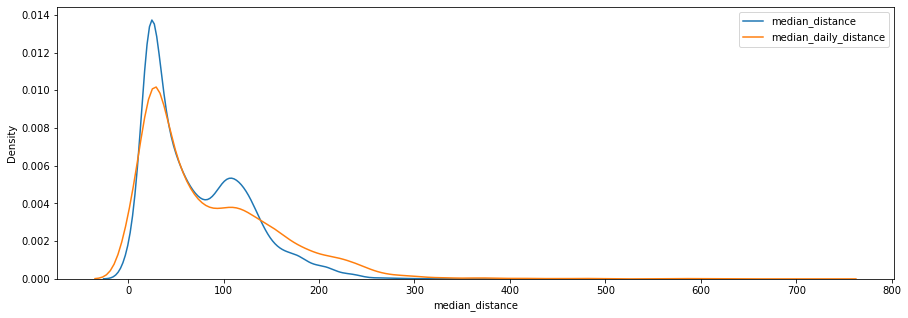

In [ ]:
fig = plt.figure(figsize=(15,5))
sns.kdeplot(all_distance['median_distance'], label = 'median_distance')
sns.kdeplot(all_distance['median_daily_distance'], label = 'median_daily_distance')

plt.legend()
plt.show()

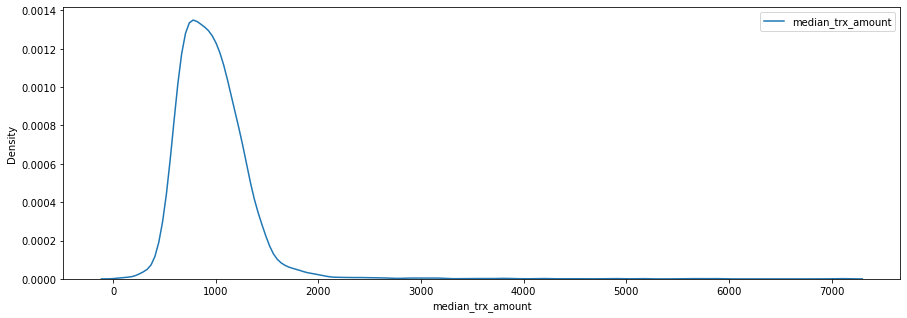

In [ ]:
fig = plt.figure(figsize=(15,5))
sns.kdeplot(all_distance['median_trx_amount'], label = 'median_trx_amount')

plt.legend()
plt.show()

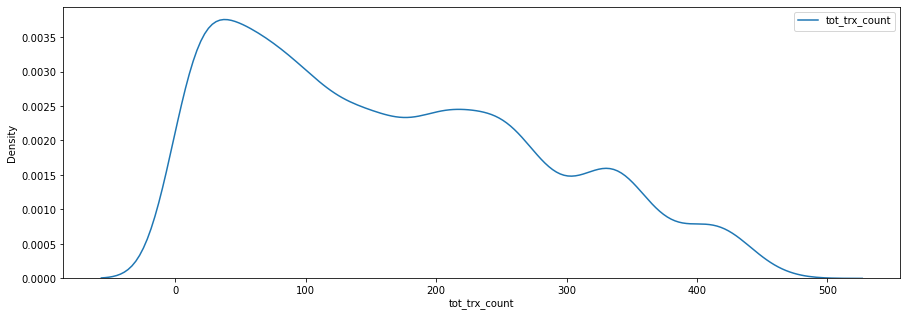

In [ ]:
fig = plt.figure(figsize=(15,5))
sns.kdeplot(all_distance['tot_trx_count'], label = 'tot_trx_count')

plt.legend()
plt.show()

In [ ]:
### Create group for median_distance - Group is based on the data distribution
bins, labels = pd.cut(
    x=all_distance['median_distance'], 
    bins=[-float("inf"), 50, 150, float("inf")],
    labels=['LOW', 'MEDIUM', 'HIGH'],
    retbins=True)

all_distance['median_distance_group'] = bins

### Create group for median_trx_amount - Group is based on the data distribution
bins, labels = pd.cut(
    x=all_distance['median_trx_amount'], 
    bins=[-float("inf"), 500, 1000, float("inf")],
    labels=['LOW', 'MEDIUM', 'HIGH'],
    retbins=True)

all_distance['median_trx_amount_group'] = bins


### Create group for tot_trx_count
bins, labels = pd.cut(
    x=all_distance['tot_trx_count'], 
    bins=[-float("inf"), 100, 200, float("inf")],
    labels=['LOW', 'MEDIUM', 'HIGH'],
    retbins=True)

all_distance['tot_trx_count_group'] = bins

### Create group for median_daily_distance - Group is based on the data distribution
bins, labels = pd.cut(
    x=all_distance['median_daily_distance'], 
    bins=[-float("inf"), 50, 150, float("inf")],
    labels=['LOW', 'MEDIUM', 'HIGH'],
    retbins=True)

all_distance['median_daily_distance_group'] = bins

In [ ]:
all_distance.head()

,user_id,median_distance,median_daily_distance,median_trx_amount,tot_trx_count,median_distance_group,median_trx_amount_group,tot_trx_count_group,median_daily_distance_group
0,00073cc2-c801-c67c-d039-fca63c78c6a9,32.492416,11.372224,953.0,112,LOW,MEDIUM,MEDIUM,LOW
1,000b6710-f8b4-ddd4-1913-90c7d424fccf,18.417210,15.458092,1214.0,183,LOW,HIGH,MEDIUM,LOW
2,00183cfe-ceb0-9220-7984-f33f61c61ae4,33.591164,37.570253,1302.0,374,LOW,HIGH,HIGH,LOW
3,001b10c4-0ec1-68c9-a059-0a44159119bd,11.806901,14.230358,920.5,203,LOW,MEDIUM,HIGH,LOW
4,0021b632-3246-b7d9-bb29-66398e4a295d,30.279938,28.597604,1189.0,217,LOW,HIGH,HIGH,LOW


In [ ]:
dist_amount = pd.crosstab(all_distance['median_distance_group'], all_distance['median_trx_amount_group'])
dist_amount.index.names = ['Travel Distance Group']
dist_count = pd.crosstab(all_distance['median_distance_group'], all_distance['tot_trx_count_group'])
dist_count.index.names = ['Travel Distance Group']

daily_dist_amount = pd.crosstab(all_distance['median_daily_distance_group'], all_distance['median_trx_amount_group'])
daily_dist_amount.index.names = ['Travel DAILY Distance Group']
daily_dist_count = pd.crosstab(all_distance['median_daily_distance_group'], all_distance['tot_trx_count_group'])
daily_dist_count.index.names = ['Travel DAILY Distance Group']

In [ ]:
dist_count

tot_trx_count_group,LOW,MEDIUM,HIGH
Travel Distance Group,,,
LOW,1554,963,1502
MEDIUM,1331,1018,1499
HIGH,338,148,234


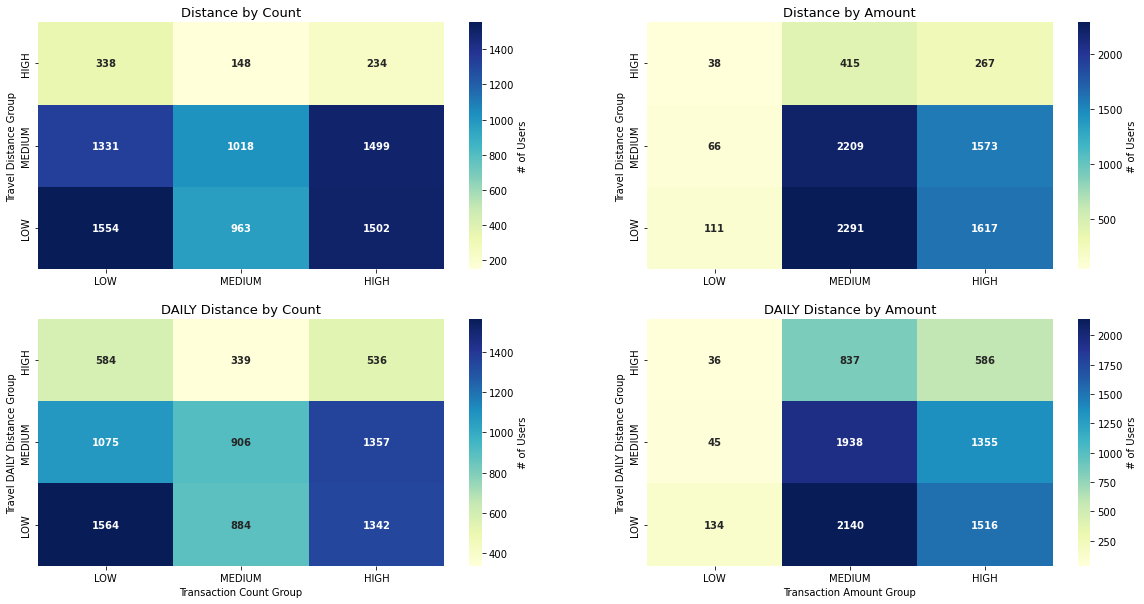

In [ ]:
fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(221)
sns.heatmap(dist_count,cmap="YlGnBu", ax=ax1, 
            cbar_kws={'label': '# of Users'}, 
            annot=True, fmt='g', annot_kws={'fontweight':'bold'}
           )
ax1.invert_yaxis()
ax1.set_xlabel('')
ax1.set_title('Distance by Count', size = 13)

ax2 = fig.add_subplot(222)
sns.heatmap(dist_amount,cmap="YlGnBu", ax=ax2, 
            cbar_kws={'label': '# of Users'}, 
            annot=True, fmt='g', annot_kws={'fontweight':'bold'}
           )
ax2.invert_yaxis()
ax2.set_xlabel('')
ax2.set_title('Distance by Amount', size = 13)

ax3 = fig.add_subplot(223)
sns.heatmap(daily_dist_count,cmap="YlGnBu", ax=ax3, 
            cbar_kws={'label': '# of Users'}, 
            annot=True, fmt='g', annot_kws={'fontweight':'bold'}
           )
ax3.invert_yaxis()
ax3.set_xlabel('Transaction Count Group')
ax3.set_title('DAILY Distance by Count', size = 13)

ax4 = fig.add_subplot(224)
sns.heatmap(daily_dist_amount,cmap="YlGnBu", ax=ax4, 
            cbar_kws={'label': '# of Users'}, 
            annot=True, fmt='g', annot_kws={'fontweight':'bold'}
           )
ax4.invert_yaxis()
ax4.set_xlabel('Transaction Amount Group')
ax4.set_title('DAILY Distance by Amount', size = 13)


plt.show()

| Groups | LOW | MEDIUM | HIGH |
| --- | --- | --- | --- |
| Transaction Count Group | ≤ 100 | > 100 and ≤ 200 | > 200 |
| Transaction Amount Group | ≤ 500 | > 500 and ≤ 1000 | > 1000 |
| Travel Distance Group (in Km) | ≤ 50 | > 50 and ≤ 150 | > 150 |
| Travel DAILY Distance Group (in Km) | ≤ 50 | > 50 and ≤ 150 | > 150 |

**Takeaways:**
* No discernible pattern emerged from <u>overall distance</u> and <u>daily distance</u>
* **Distance by Count & Daily Distance by Count**
    * Looking at these two charts , users who travel further are tend to have lower number of transaction. This could be due to the fact that they are on the move more than other groups of people. Hence they are less likely to carry many things with them.
    * **Recommendation:** 
        1. We could push users who have high mobility to purchase more on online purchases such us e-commerce, mobile data package, and so on. They still could make a purchase online while they are on the move.
        2. Public Transportation package.
        3. Insurance
        4. Order ahead for self pick up.
* **Distance by Amount & Daily Distance by Amount**
    * Based on the next two charts, it is obvious that there is an increasing number of Users as they travel less. This could be due to users who travel less might live in the urban area where things are more expensive, but the availability of items can be found in many places.
    * **Recommendation:** Using this grouping mechanism, we can proxy users who are more likely to live in urban VS those who live in suburban or even rural area. Since urban users tend to have higher buying power, should there be any promo that will be launched, they can be given less discount than those who live further than the urban area.

# 4. Modeling For Each User's GMV

## 4.1 Feature Engineering

### Creating labels dataset

In this part we're going to create set of features for modeling purposes. The steps are as follows:
1. Create a datamart which aggregates Daily Transaction based on common behavior for each user
2. Create look back features according to set cutoff_date, for instance:
  * sum_trx_amount_l7d: Sum of transaction amount in the past 7 days
  * sum_trx_count_day_l180d: sum of transaction count in the past 180 days
3. The labels will be total number of Transaction Amount (GMV) per user in the next month after the cutoff date. If cutoff date is at November 30th, then the labels will be total number of GMV per user for the month of December

In [ ]:
DATE_FORMAT = '%Y-%m-%d'

In [ ]:
trx_raw = pd.read_csv(f"{configs['INTERMEDIATE_PATH']}/trx_fin_raw.csv")

In [ ]:
trx_raw['trx_datetime'] = pd.to_datetime(trx_raw['trx_datetime'])

In [ ]:
"""
EXTRACT TIME BASED FEATURES
"""

trx_raw['month'] = trx_raw['trx_datetime'].dt.month
trx_raw['year'] = trx_raw['trx_datetime'].dt.year
trx_raw['monthyear'] = trx_raw['year'].astype(str) + trx_raw['month'].map("{:02}".format)
trx_raw['is_weekend'] = (trx_raw['trx_datetime'].dt.weekday >= 5).astype(int)
trx_raw['is_weekday'] = (trx_raw['trx_datetime'].dt.weekday < 5).astype(int)
trx_raw['trx_amount_weekend'] = np.where(
    trx_raw['is_weekend'] == 1,
    trx_raw['trx_amount'],
    0
)
trx_raw['trx_amount_weekday'] = np.where(
    trx_raw['is_weekday'] == 1,
    trx_raw['trx_amount'],
    0
)
trx_raw['trx_hour'] = trx_raw['trx_datetime'].dt.hour
trx_raw['trx_day'] = np.where(
    (trx_raw['trx_hour'] >= 9) &
    (trx_raw['trx_hour'] <= 18),
    1,
    0
)
trx_raw['trx_night'] = np.where(
    (trx_raw['trx_hour'] < 9) |
    (trx_raw['trx_hour'] > 18),
    1,
    0
)

trx_raw['trx_amount_day'] = np.where(
    trx_raw['trx_day'] == 1,
    trx_raw['trx_amount'],
    0
)

trx_raw['trx_amount_night'] = np.where(
    trx_raw['trx_night'] == 1,
    trx_raw['trx_amount'],
    0
)

In [ ]:
trx_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1582260 entries, 0 to 1582259
Data columns (total 25 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   trx_id              1582260 non-null  object        
 1   user_id             1582260 non-null  object        
 2   store_id            1582260 non-null  object        
 3   trx_datetime        1582260 non-null  datetime64[ns]
 4   trx_amount          1582260 non-null  int64         
 5   trx_date            1582260 non-null  object        
 6   gender              1421978 non-null  object        
 7   age                 1505614 non-null  float64       
 8   nam                 1582260 non-null  object        
 9   laa                 1582260 non-null  object        
 10  lat                 1582260 non-null  float64       
 11  lon                 1582260 non-null  float64       
 12  category            1582260 non-null  object        
 13  month       

In [ ]:
trx_raw[(trx_raw['trx_hour'] < 9) | (trx_raw['trx_hour'] > 18)][['trx_day', 'trx_night']].drop_duplicates()

,trx_day,trx_night
0,0,1


In [ ]:
trx_raw[(trx_raw['trx_hour'] >= 9) & (trx_raw['trx_hour'] <= 18)][['trx_day', 'trx_night']].drop_duplicates()

,trx_day,trx_night
1,1,0


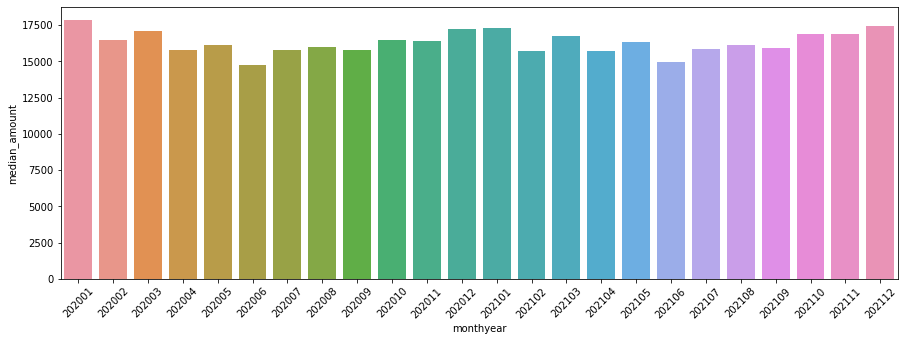

In [ ]:
monthly_trx = trx_raw.groupby(
    ['user_id', 'monthyear'],
    as_index = False,
    observed = True
).agg(
    monthly_amount = ('trx_amount', 'sum')
)

median_monthly_trx = monthly_trx.groupby(
    ['monthyear'],
    as_index = False,
    observed = True
).agg(
    median_amount = ('monthly_amount', 'median')
)
median_monthly_trx.sort_values('monthyear', ascending=True, inplace = True)

fig = plt.figure(figsize = (15,5))
sns.barplot(x = 'monthyear', y = 'median_amount', data = median_monthly_trx)
plt.xticks(rotation=45)
plt.show()

* Median of GMV plummeted from January to June and raised back up again until the end of the year. This pattern happened in both 2020 and 2021.
* By looking at this pattern, we would expect that the prediction for median GMV in January 2022 should be lower than December 2021.

In [ ]:
next_month = str(configs['CUTOFF_DATE'].year) + str(configs['CUTOFF_DATE'].month+1).zfill(2)
tot_users_dec_trx = monthly_trx.query(f'monthyear == "{next_month}"')['user_id'].nunique()
tot_users = trx_raw[['user_id']].drop_duplicates().shape[0]
print(
    f"""
    CUTOFF MONTH = {str(configs['CUTOFF_DATE'].year) + str(configs['CUTOFF_DATE'].month).zfill(2)}
    NEXT MONTH = {next_month}
    # of users total = {tot_users} 
    # of users transacted in {next_month} = {tot_users_dec_trx} ({tot_users_dec_trx/tot_users:.02%})
    """
)


    CUTOFF MONTH = 202111
    NEXT MONTH = 202112
    # of users total = 9542 
    # of users transacted in 202112 = 8850 (92.75%)
    


In [ ]:
"""
Building the datamart by aggregating daily amount per user for different types of transaction behavior, such as time based transaction.
"""
cutoff_monthyear = str(configs['CUTOFF_DATE'].year) + str(configs['CUTOFF_DATE'].month).zfill(2)
print(cutoff_monthyear)
daily_trx = trx_raw[trx_raw['monthyear'] <= cutoff_monthyear].groupby(
    ['user_id', 'trx_date'],
    as_index = False,
    observed = True
).agg(
    daily_amount = ('trx_amount', 'sum'),
    trx_count = ('trx_amount', 'size'),
    trx_count_weekend = ('is_weekend', 'sum'),
    trx_count_weekday = ('is_weekday', 'sum'),
    trx_amount_weekend = ('trx_amount_weekend', 'sum'),
    trx_amount_weekday = ('trx_amount_weekday', 'sum'),
    trx_count_day = ('trx_day', 'sum'),
    trx_count_night = ('trx_night', 'sum'),
    trx_amount_day = ('trx_amount_day', 'sum'),
    trx_amount_night = ('trx_amount_night', 'sum')
)
daily_trx['active_day'] = 1
daily_trx['trx_date'].min(), daily_trx['trx_date'].max()

202111


('2020-01-01', '2021-11-30')

In [ ]:
# test_df = daily_trx[daily_trx['user_id'] == '00073cc2-c801-c67c-d039-fca63c78c6a9']
# print(test_df.shape)
# test_df.head()

In [ ]:
configs['CUTOFF_DATE'].strftime(DATE_FORMAT)

'2021-11-30'

In [ ]:
def suffix_timestamp(target_date_dt, time_range):
        """
        Create dictionary with suffix and the corresponding start date and end date value.
        """
        times = {
            'l7d': [target_date_dt - datetime.timedelta(days=7), target_date_dt],
            'l14d': [target_date_dt - datetime.timedelta(days=14), target_date_dt],
            'l30d': [target_date_dt - datetime.timedelta(days=30), target_date_dt],
            'l90d': [target_date_dt - datetime.timedelta(days=90), target_date_dt],
            'l180d': [target_date_dt - datetime.timedelta(days=180), target_date_dt]
        }

        return {k: times.get(k) for k in time_range}

In [ ]:
# test_df_users = test_df[['user_id']].drop_duplicates()
# test_df_users

agg_prefix = {
    'daily_amount': ['mean', 'sum', 'min', 'max'],
    'trx_count': ['mean', 'sum', 'max'],
    'active_day': ['mean', 'sum'],
    'trx_count_weekend': ['sum', 'max'],
    'trx_count_weekday': ['sum', 'max'],
    'trx_amount_weekend': ['sum', 'max'],
    'trx_amount_weekday': ['sum', 'max'],
    'trx_count_day': ['sum', 'max'],
    'trx_count_night': ['sum', 'max'],
    'trx_amount_day': ['sum', 'max'],
    'trx_amount_night': ['sum', 'max']
}

time_range = [
    'l7d', # Last 7 DAYS from the cutoff date
    'l14d', # Last 14 DAYS from the cutoff date
    'l30d', # Last 30 DAYS from the cutoff date
    'l90d', # Last 90 DAYS from the cutoff date
    'l180d' # Last 180 DAYS from the cutoff date
]

suffix_daterange_map = suffix_timestamp(configs['CUTOFF_DATE'], time_range)
suffix_daterange_map
print(suffix_daterange_map)

all_users = trx_raw[['user_id']].drop_duplicates()
print(f"shape before: {all_users.shape}")

for suffix, date_range in suffix_daterange_map.items():
    for agg_ix, agg_val in agg_prefix.items():
        for agg in agg_val:
            
            if agg_ix in ['trx_count', 'active_day'] and agg == 'mean':
                agg_test = daily_trx[ # test_df
                    (pd.to_datetime(daily_trx['trx_date']) <= date_range[1].strftime(DATE_FORMAT)) &
                    (pd.to_datetime(daily_trx['trx_date']) > date_range[0].strftime(DATE_FORMAT))
                ].groupby(
                    ['user_id'],
                    as_index = False,
                    observed = True
                ).agg(
                    {
                        agg_ix: 'sum'
                    }
                )
                
                agg_test[agg_ix] = agg_test[agg_ix] / int(suffix[1:-1])
            else:
                agg_test = daily_trx[ # test_df
                    (pd.to_datetime(daily_trx['trx_date']) <= date_range[1].strftime(DATE_FORMAT)) &
                    (pd.to_datetime(daily_trx['trx_date']) > date_range[0].strftime(DATE_FORMAT))
                ].groupby(
                    ['user_id'],
                    as_index = False,
                    observed = True
                ).agg(
                    {
                        agg_ix: agg
                    }
                )
            agg_test.columns = ['user_id', f'{agg}_{agg_ix}_{suffix}']
            
            all_users = all_users.merge(
                agg_test,
                how = 'left',
                left_on = 'user_id',
                right_on = 'user_id'
            )
            
### FIND WEEKEND WEEKDAY COLUMNS AND CALCULATE MEAN TRX AMOUNT WEEKEND WEEKDAY
all_cols = list(all_users.columns) # test_df_users
r = re.compile(".*sum.*_amount_(weekday|weekend).*")
weekend_day_cols = list(filter(r.match, all_cols)) 

for i in weekend_day_cols:
    midfix_list = i.split('_')[1:-1]
    midfix = "_".join(midfix_list)
    suffix = i.split('_')[-1]
    full_col_name = f'mean_{midfix}_{suffix}'
    
    midfix_list[1] = 'count'
    denom_col_name = f'sum_{"_".join(midfix_list)}_{suffix}'
    all_users[full_col_name] = all_users[i] / all_users[denom_col_name]

### FIND DAY AND NIGHT COLUMNS AND CALCULATE MEAN TRX AMOUNT DAY AND NIGHT
all_cols = list(all_users.columns) # test_df_users
r = re.compile(".*sum.*_amount_(day|night).*")
day_night_cols = list(filter(r.match, all_cols)) 

for i in day_night_cols:
    midfix_list = i.split('_')[1:-1]
    midfix = "_".join(midfix_list)
    suffix = i.split('_')[-1]
    full_col_name = f'mean_{midfix}_{suffix}'
    
    midfix_list[1] = 'count'
    denom_col_name = f'sum_{"_".join(midfix_list)}_{suffix}'
    all_users[full_col_name] = all_users[i] / all_users[denom_col_name]

### GETTING THE LABELS OF TOTAL NEXT MONTH GMV
cutoff_next_month = str(configs['CUTOFF_DATE'].year) + str(configs['CUTOFF_DATE'].month+1).zfill(2)
all_users = all_users.merge(
    monthly_trx[monthly_trx['monthyear'] == cutoff_next_month].drop(['monthyear'], axis = 1),
    how = 'left',
    left_on = 'user_id',
    right_on = 'user_id'
)
print(f"shape after: {all_users.shape}")

{'l7d': [datetime.date(2021, 11, 23), datetime.date(2021, 11, 30)], 'l14d': [datetime.date(2021, 11, 16), datetime.date(2021, 11, 30)], 'l30d': [datetime.date(2021, 10, 31), datetime.date(2021, 11, 30)], 'l90d': [datetime.date(2021, 9, 1), datetime.date(2021, 11, 30)], 'l180d': [datetime.date(2021, 6, 3), datetime.date(2021, 11, 30)]}
shape before: (9542, 1)
shape after: (9542, 147)


<ipython-input-31-3a8b339c3fbb>:87: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  all_users[full_col_name] = all_users[i] / all_users[denom_col_name]
<ipython-input-31-3a8b339c3fbb>:102: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  all_users[full_col_name] = all_users[i] / all_users[denom_col_name]


In [ ]:
all_users[
    # ['sum_trx_amount_weekend_l7d', 
    #  'sum_trx_count_weekend_l7d', 
    #  'mean_trx_amount_weekend_l7d',
    #  'sum_trx_amount_weekend_l180d', 
    #  'sum_trx_count_weekend_l180d', 
    #  'mean_trx_amount_weekend_l180d',
    #  'sum_trx_amount_weekend_l90d', 
    #  'sum_trx_count_weekend_l90d', 
    #  'mean_trx_amount_weekend_l90d',
    #  'sum_trx_amount_weekend_l30d', 
    #  'sum_trx_count_weekend_l30d', 
    #  'mean_trx_amount_weekend_l30d'
    # ]
    list(all_users.columns[:5]) + list(all_users.columns[-5:])
].head()


,user_id,mean_daily_amount_l7d,sum_daily_amount_l7d,min_daily_amount_l7d,max_daily_amount_l7d,mean_trx_amount_day_l90d,mean_trx_amount_night_l90d,mean_trx_amount_day_l180d,mean_trx_amount_night_l180d,monthly_amount
0,93098549-3ff0-e579-01c3-df9183278f64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1f8a8d4e-dec8-e4da-7c8e-901e84151b73,1151.333333,3454.0,526.0,1490.0,690.500000,4878.0,790.653846,1812.20,25843.0
2,4502d7f8-54a1-396c-e9ab-fb0d9be57401,5250.000000,5250.0,5250.0,5250.0,2018.973684,NaN,2307.848101,1391.00,58142.0
3,41f5d7dc-deda-5cd0-31ce-d96df44181ec,1285.500000,2571.0,1196.0,1375.0,1823.375000,1062.0,1810.109375,2324.25,22116.0
4,a800c6f7-3776-b599-a70a-e3961bd01b16,NaN,NaN,NaN,NaN,2026.600000,254.0,1710.285714,1597.50,5277.0


In [ ]:
# test_df_users.info()
all_users.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9542 entries, 0 to 9541
Data columns (total 147 columns):
 #    Column                         Non-Null Count  Dtype  
---   ------                         --------------  -----  
 0    user_id                        9542 non-null   object 
 1    mean_daily_amount_l7d          7920 non-null   float64
 2    sum_daily_amount_l7d           7920 non-null   float64
 3    min_daily_amount_l7d           7920 non-null   float64
 4    max_daily_amount_l7d           7920 non-null   float64
 5    mean_trx_count_l7d             7920 non-null   float64
 6    sum_trx_count_l7d              7920 non-null   float64
 7    max_trx_count_l7d              7920 non-null   float64
 8    mean_active_day_l7d            7920 non-null   float64
 9    sum_active_day_l7d             7920 non-null   float64
 10   sum_trx_count_weekend_l7d      7920 non-null   float64
 11   max_trx_count_weekend_l7d      7920 non-null   float64
 12   sum_trx_count_weekday_l7d      7

In [ ]:
configs['FINAL_PATH']

'data/03.final'

In [ ]:
### STORE THE FEATURES TO CSV
all_users.to_csv(f"{configs['FINAL_PATH']}/full_features.csv", index = False)

## 4.2 Feature Selection & Model Training

<b><h3>NOTE:</h></b>
Choosing XGBoost as the algorithm to train the model. With this model, it is unnecessary to normalize or standardize the training data.


In [ ]:
fin_ft = pd.read_csv(f"{configs['FINAL_PATH']}/full_features.csv")

In [ ]:
fin_ft.columns[:5], fin_ft.columns[-5:]

(Index(['user_id', 'mean_daily_amount_l7d', 'sum_daily_amount_l7d',
        'min_daily_amount_l7d', 'max_daily_amount_l7d'],
       dtype='object'),
 Index(['mean_trx_amount_day_l90d', 'mean_trx_amount_night_l90d',
        'mean_trx_amount_day_l180d', 'mean_trx_amount_night_l180d',
        'monthly_amount'],
       dtype='object'))

In [ ]:
FEATURE_COLS = list(fin_ft.drop(['user_id', 'monthly_amount'], axis = 1).columns)
LABEL_COL = 'monthly_amount'

In [ ]:
"""
SPLIT THE DATASET
"""
X_train, X_test, y_train, y_test = train_test_split(fin_ft[FEATURE_COLS], fin_ft[LABEL_COL], test_size=0.3, random_state=222)

In [ ]:
X_train.to_csv(f"{configs['FINAL_PATH']}/X_train.csv", index = False)
X_test.to_csv(f"{configs['FINAL_PATH']}/X_test.csv", index = False)
pd.DataFrame(y_train).to_csv(f"{configs['FINAL_PATH']}/y_train.csv", index = False)
pd.DataFrame(y_test).to_csv(f"{configs['FINAL_PATH']}/y_test.csv", index = False)

In [ ]:
print(f"""
  Train: {X_train.shape}, {y_train.shape}
  Test: {X_test.shape}, {y_test.shape}
""")


  Train: (6679, 145), (6679,)
  Test: (2863, 145), (2863,)



In [ ]:
"""
FILLING NA WITH 0s
"""
X_train.fillna(0,inplace = True)
y_train.fillna(0,inplace = True)
X_test.fillna(0,inplace = True)
y_test.fillna(0,inplace = True)

In [ ]:
X_train.isna().sum()

mean_daily_amount_l7d          0
sum_daily_amount_l7d           0
min_daily_amount_l7d           0
max_daily_amount_l7d           0
mean_trx_count_l7d             0
                              ..
mean_trx_amount_night_l30d     0
mean_trx_amount_day_l90d       0
mean_trx_amount_night_l90d     0
mean_trx_amount_day_l180d      0
mean_trx_amount_night_l180d    0
Length: 145, dtype: int64

#### Check VIF for multicollinearity.

In [ ]:
vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif_info['Column'] = X_train.columns
vif_info.sort_values('VIF', ascending=False)

/usr/local/lib/python3.8/dist-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF,Column
119,inf,sum_trx_count_night_l180d
59,inf,sum_trx_count_weekend_l30d
71,inf,sum_trx_amount_day_l30d
115,inf,sum_trx_amount_weekday_l180d
69,inf,sum_trx_count_night_l30d
...,...,...
127,10.554938,mean_trx_amount_weekend_l14d
77,7.384521,min_daily_amount_l90d
102,6.616997,min_daily_amount_l180d
52,3.620450,min_daily_amount_l30d


In [ ]:
"""
Setting a threshold of VIF < 100 to
"""
vif_thresh = 100
vif_cols = vif_info[vif_info['VIF'] < vif_thresh]['Column'].values.tolist()
len(vif_cols), vif_cols[:5], vif_cols[-5:]

(39,
 ['min_daily_amount_l7d',
  'max_trx_count_weekend_l7d',
  'max_trx_count_weekday_l7d',
  'max_trx_count_night_l7d',
  'mean_daily_amount_l14d'],
 ['mean_trx_amount_day_l14d',
  'mean_trx_amount_night_l14d',
  'mean_trx_amount_night_l30d',
  'mean_trx_amount_night_l90d',
  'mean_trx_amount_night_l180d'])

In [ ]:
def select_k_features(X_train, y_train, X_test, score_func = f_regression, k = 'all'):
  fs = SelectKBest(score_func=score_func, k=k)
  # fit
  fs.fit(X_train, y_train)
  # transform train and test data
  X_train_fs = fs.transform(X_train)
  X_test_fs = fs.transform(X_test)

  return X_train_fs, X_test_fs, fs

In [ ]:
"""
Select features using f_regression function from set of features WITH LOW VIF 
"""

performance_freg = {
    'k': list(),
    'train_score': list(),
    'test_score': list()
}

k_values = list(range(3,X_train[vif_cols].shape[1],3)) + ['all']

for k in k_values:
  X_train_freg, X_test_freg, freg = select_k_features(
      X_train, 
      y_train, 
      X_test, 
      score_func = f_regression, 
      k = k
  )
  ### TRAIN MODEL WITH DEFAULT PARAMS EXCEPT n_estimators
  xgbm = xgb.XGBRegressor(
      n_estimators = 1000,
      # max_depth = 8,
      # learning_rate = 0.08,
  #     gamma = 1,
      # reg_alpha = 1,
  #     min_child_weight = 3,
      # subsample = 0.7,
  #     max_delta_step = 1,
      # colsample_bytree = 0.5,
  #     colsample_bylevel = 0.5,
      eval_metric = ['rmse'],
      seed = 1234
  )

  xgbm.fit(
      X_train_freg, 
      y_train, 
      eval_set=[(X_train_freg, y_train), (X_test_freg, y_test)],
      early_stopping_rounds = 100,
      verbose = 200
  )

  train_pred = xgbm.predict(X_train_freg, ntree_limit=xgbm.get_booster().best_ntree_limit)
  test_pred = xgbm.predict(X_test_freg, ntree_limit=xgbm.get_booster().best_ntree_limit)
  # evaluate predictions
  train_rmse = mean_squared_error(y_train, train_pred, squared=False)
  test_rmse = mean_squared_error(y_test, test_pred, squared=False)

  performance_freg['k'].append(str(k))
  performance_freg['train_score'].append(train_rmse)
  performance_freg['test_score'].append(test_rmse)

performance_freg_pd = pd.DataFrame(performance_freg)

[01:35:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:24973.5	validation_1-rmse:29365.9
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
Stopping. Best iteration:
[37]	validation_0-rmse:16225.5	validation_1-rmse:22650

[01:35:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:24972.4	validation_1-rmse:29368.3
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
Stopping. Best iteration:
[39]	validation_0-rmse:16154.7	validation_1-rmse:22653.5

[01:35:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse

In [ ]:
performance_freg_pd

,k,train_score,test_score
0,3,16225.568349,22650.092428
1,6,16154.730616,22653.538925
2,9,15747.652635,22535.855003
3,12,15860.981250,22598.879676
4,15,15801.493404,22566.382035
5,18,15405.578706,22463.538677
6,21,15375.564582,22438.183006
7,24,15403.351638,22428.979470
8,27,15425.372026,22412.652627
9,30,15443.816686,22407.619121


In [ ]:
"""
Select features using mutual_info_regression function from set of features WITH LOW VIF 
"""

performance_mir = {
    'k': list(),
    'train_score': list(),
    'test_score': list()
}

k_values = list(range(3,X_train[vif_cols].shape[1],3)) + ['all']

for k in k_values:
  X_train_mir, X_test_mir, mir = select_k_features(
      X_train, 
      y_train, 
      X_test, 
      score_func = mutual_info_regression, 
      k = k
  )
  ### TRAIN MODEL WITH DEFAULT PARAMS EXCEPT n_estimators
  xgbm = xgb.XGBRegressor(
      n_estimators = 1000,
      # max_depth = 8,
      # learning_rate = 0.08,
  #     gamma = 1,
      # reg_alpha = 1,
  #     min_child_weight = 3,
      # subsample = 0.7,
  #     max_delta_step = 1,
      # colsample_bytree = 0.5,
  #     colsample_bylevel = 0.5,
      eval_metric = ['rmse'],
      seed = 1234
  )

  xgbm.fit(
      X_train_mir, 
      y_train, 
      eval_set=[(X_train_mir, y_train), (X_test_mir, y_test)],
      early_stopping_rounds = 100,
      verbose = 200
  )

  train_pred = xgbm.predict(X_train_mir, ntree_limit=xgbm.get_booster().best_ntree_limit)
  test_pred = xgbm.predict(X_test_mir, ntree_limit=xgbm.get_booster().best_ntree_limit)
  # evaluate predictions
  train_rmse = mean_squared_error(y_train, train_pred, squared=False)
  test_rmse = mean_squared_error(y_test, test_pred, squared=False)

  performance_mir['k'].append(str(k))
  performance_mir['train_score'].append(train_rmse)
  performance_mir['test_score'].append(test_rmse)

performance_mir_pd = pd.DataFrame(performance_mir)

[01:37:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:24975.3	validation_1-rmse:29370.6
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
Stopping. Best iteration:
[36]	validation_0-rmse:16183.9	validation_1-rmse:22590.1

[01:37:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:24959.4	validation_1-rmse:29362.3
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
Stopping. Best iteration:
[33]	validation_0-rmse:15862.5	validation_1-rmse:22517.5

[01:37:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rm

In [ ]:
performance_mir_pd

,k,train_score,test_score
0,3,16183.812620,22590.028030
1,6,15862.454474,22517.496873
2,9,15692.180178,22436.332363
3,12,15631.984738,22432.128489
4,15,15572.132684,22420.524950
5,18,15375.986719,22396.534927
6,21,15418.029561,22418.160965
7,24,15364.597083,22457.950718
8,27,15270.113237,22401.975862
9,30,15274.727014,22414.528253


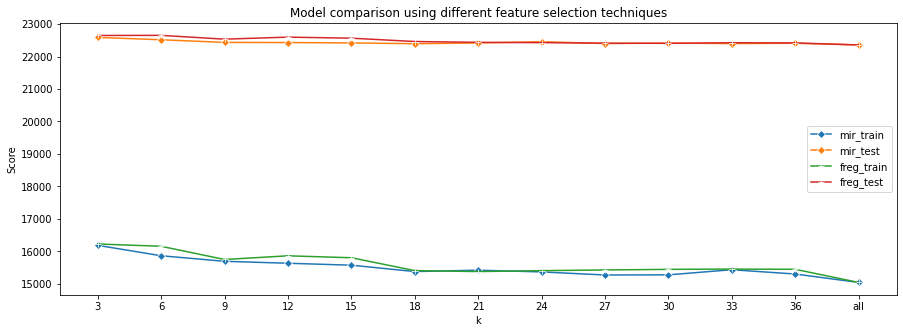

In [ ]:
fig = plt.figure(figsize=(15,5))
sns.lineplot(x='k',y='train_score',data=performance_mir_pd, label = 'mir_train', marker = 'D')
sns.lineplot(x='k',y='test_score',data=performance_mir_pd, label = 'mir_test', marker = 'D')
sns.lineplot(x='k',y='train_score',data=performance_freg_pd, label = 'freg_train', marker = '+')
sns.lineplot(x='k',y='test_score',data=performance_freg_pd, label = 'freg_test', marker = '+')

plt.title("Model comparison using different feature selection techniques")
plt.ylabel("Score")
plt.legend()
plt.show()

* In general, using **mutual_info_regression (mir)** (blue line and orange line) resulted into slightly better performance compared to using **f_regression (freg)**.
* The model is overfit using both feature selection technique, and will be addressed in the next segment by tuning the hyperparameter.
* The optimal *k* for **f_regression** is 30 with RMSE of test data = 22407.6. 
* The lowest rmse in **mir** features falls on *k = 33* with RMSE of test data = 22400.5. Because if we choose higher than that, then the rmse of test set goes back up while train set goes down. This is a typical **overfitting** scenario.

<b><h3>Conclusion:</h3></b> Will use **mutual_info_regression** with *k = 33* as the feature selection before tuning the hyperparameter of the model.

<b><h3>Further Improvement For Feature Selection:</h3></b>
* We also can do ensembly techniques by looping over *N* times with each *N* we are creating a simple model then record the feature importance and the model performance. Before moving on to the next iteration, we would delete features with importance lower than our set threshold. Then we can see the next iteration's performance using the new set of features.
* Add more attributes to the training dataset such as number of store visited per time derivative ie. l7d, l14d, and so on
* Add users' attributes such as gender, age, first transaction, last transaction and dissecting the categories of the transaction.
* Add users' distance to the training dataset.

## 4.3 Hyperparameter Tuning

FIXING OVERFITTING ISSUE

In [ ]:
X_train_opt, X_test_opt, opt = select_k_features(
      X_train, 
      y_train, 
      X_test, 
      score_func = mutual_info_regression, 
      k = 33
  )

In [ ]:
pd.DataFrame({
    'opt_columns': opt.get_feature_names_out()
}).to_csv(f"{configs['FINAL_PATH']}/opt_columns.csv", index=False)

In [ ]:
""" 
excluded_cols is based on the feature importance with importance < 0.03
"""
excluded_cols = ['sum_trx_count_l90d', 'sum_trx_count_day_l90d', 'mean_trx_count_l180d', 'sum_active_day_l30d', 
                 'mean_active_day_l90d', 'min_daily_amount_l30d', 'sum_trx_count_l180d', 'sum_trx_count_day_l30d', 
                 'sum_trx_count_day_l14d', 'mean_trx_count_l90d', 'sum_trx_count_weekday_l90d', 'max_trx_count_l30d', 
                 'sum_trx_amount_weekday_l30d', 'max_trx_count_day_l30d', 'sum_trx_count_weekend_l90d', 
                 'sum_trx_count_weekday_l30d']
opt_columns = pd.read_csv(f"{configs['FINAL_PATH']}/opt_columns.csv")
opt_columns = opt_columns['opt_columns'].values.tolist()
opt_columns = [x for x in opt_columns if x not in excluded_cols]
# Save as FINAL_COLS
pd.DataFrame({
    'final_columns': opt_columns
}).to_csv(f"{configs['FINAL_PATH']}/final_columns.csv", index=False)

len(opt_columns), opt_columns[:5], opt_columns[-5:]

(17,
 ['mean_trx_count_l14d',
  'sum_trx_count_l14d',
  'max_trx_count_l14d',
  'mean_active_day_l14d',
  'sum_active_day_l14d'],
 ['sum_daily_amount_l90d',
  'sum_active_day_l90d',
  'sum_trx_amount_day_l90d',
  'sum_trx_count_day_l180d',
  'sum_trx_amount_day_l180d'])

In [ ]:
xgbm_opt = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators = 5000,
    max_depth = 3,
    learning_rate = 0.01,
    gamma = 20,
    reg_alpha = 10,
    min_child_weight = 20,
    subsample = 0.5,
    # max_delta_step = 1,
    colsample_bytree = 0.4,
    colsample_bylevel = 0.4,
    eval_metric = ['rmse'],
    seed = 1234
)
### X_train_opt, X_test_opt
### X_train[opt_columns], X_test[opt_columns]
xgbm_opt.fit(
    X_train[opt_columns], 
    y_train, 
    eval_set=[(X_train[opt_columns], y_train), (X_test[opt_columns], y_test)], 
    early_stopping_rounds = 500,
    verbose = 100
)

train_pred = xgbm_opt.predict(X_train[opt_columns], ntree_limit=xgbm_opt.get_booster().best_ntree_limit)
test_pred = xgbm_opt.predict(X_test[opt_columns], ntree_limit=xgbm_opt.get_booster().best_ntree_limit)
# evaluate predictions
train_rmse = mean_squared_error(y_train, train_pred, squared=False)
test_rmse = mean_squared_error(y_test, test_pred, squared=False)

print(f"""
  Train RMSE: {train_rmse}
  Test RMSE: {test_rmse}
""")

[0]	validation_0-rmse:26434.2	validation_1-rmse:30601.8
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 500 rounds.
[100]	validation_0-rmse:17787.6	validation_1-rmse:23692.6
[200]	validation_0-rmse:16126.4	validation_1-rmse:22556.7
[300]	validation_0-rmse:15806.9	validation_1-rmse:22392.7
[400]	validation_0-rmse:15704.7	validation_1-rmse:22372.2
[500]	validation_0-rmse:15642.4	validation_1-rmse:22370.5
[600]	validation_0-rmse:15576.7	validation_1-rmse:22370.3
[700]	validation_0-rmse:15524	validation_1-rmse:22373.7
[800]	validation_0-rmse:15473.1	validation_1-rmse:22376.4
[900]	validation_0-rmse:15431.9	validation_1-rmse:22377.2
[1000]	validation_0-rmse:15386.2	validation_1-rmse:22378.5
Stopping. Best iteration:
[519]	validation_0-rmse:15630.3	validation_1-rmse:22369.4


  Train RMSE: 15630.255575381896
  Test RMSE: 22369.383991539995



In [ ]:
"""
SAVE MODEL
"""
file_name = f"{configs['MODEL_PATH']}/xgbm_opt.pkl"

# save
pickle.dump(xgbm_opt, open(file_name, "wb"))

<b><h3>Summary:</h3></b>

| Model | Train RMSE | Test RMSE
| --- | --- | --- |
| Pre-optimized | 15,432.53 | 22,400.56 |
| Post-optimized | 15,630.25 | 22,369.38 |

<b><h3>Conclusion:</h3></b> The model has improved a little bit by having less overfitting by looking at the small gap between Train and Test RMSE. The model has been trained in a way that it would stop whenever there was no improvement (ie. further loss) in the test data. Hence, we could save this model and use it to predict the 2022 January GMV users using December as the cutoff for feature building.

<b><h3>Further Improvement For Model Training:</h3></b>
* Do a Grid Search CV to get the better hyperparameter.
* Turn it into a multi-classification problem by labeling High, Medium, Low of the monthly amount.

#### MODEL EXPLAINABILITY

In [ ]:
xgb_ft_importance = pd.DataFrame(
    {
        'column': opt_columns,
        'feature_importance': xgbm_opt.feature_importances_
    }
).sort_values(by='feature_importance', ascending=False)

top_20_ft_importance = xgb_ft_importance.head(20).column.values.tolist()
print(xgb_ft_importance.shape,\
      xgb_ft_importance[xgb_ft_importance['feature_importance'] < 0.03]['column'].values.tolist()\
      )
xgb_ft_importance

(17, 2) []


,column,feature_importance
16,sum_trx_amount_day_l180d,0.104016
2,max_trx_count_l14d,0.098624
14,sum_trx_amount_day_l90d,0.079193
7,sum_daily_amount_l30d,0.068144
15,sum_trx_count_day_l180d,0.067278
4,sum_active_day_l14d,0.062388
3,mean_active_day_l14d,0.059218
10,mean_active_day_l30d,0.055011
13,sum_active_day_l90d,0.054445
1,sum_trx_count_l14d,0.051700


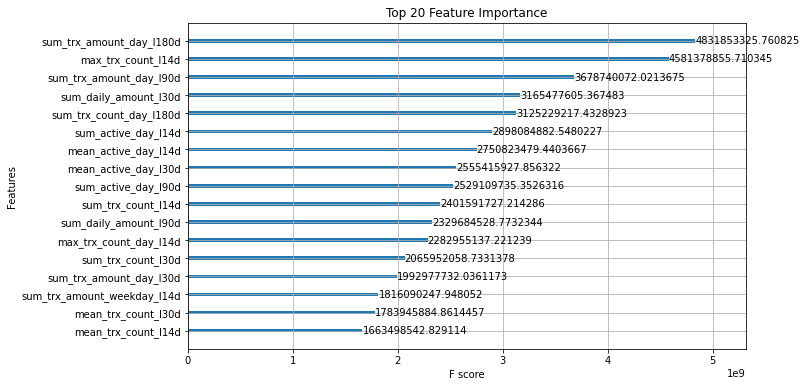

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(xgbm_opt, importance_type = 'gain', max_num_features=20, title='Top 20 Feature Importance', ax = ax)
plt.show()

<b><h3>Takeaways:</h3></b>
* Transactions that happened on the day showed up as some of the top feature importances of the model. This can be seen from 7 out top 10 important features are about transactions that happened during the day.

In [ ]:
def shap_summary_plot(model, df, features, nbr_to_show=None):
    # get shap value for each feature and its feature importance value
    # genereate two figures: shap summary plot and feature importance bar plot
    # return: a list of features sorted by feature importance
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(df[features])
    agg_shap_values = np.mean(np.abs(shap_values), axis=0)
    filtered_index = []
    filtered_features = []
    for idx, (agg_shap, feat) in enumerate(zip(agg_shap_values, features)):
        if agg_shap > 0.0001:
            filtered_index.append(idx)
            filtered_features.append(feat)
    # shap summary plot
    filtered_shap_values = shap_values[:, filtered_index]
    
    shap.summary_plot(filtered_shap_values, 
                      df[filtered_features], 
                      max_display=nbr_to_show,
                      show = False
                     )
    shap.summary_plot(filtered_shap_values, 
                      df[filtered_features], 
                      plot_type="bar", 
                      color='lightgreen', 
                      max_display=nbr_to_show,
                      show = False
                     )

    # return feature importance table 
    ranking = np.argsort(agg_shap_values)[::-1]
    features_sorted_by_shap = [features[rank] for rank in ranking]
    shap_values_sorted_by_shap = [agg_shap_values[rank] for rank in ranking]
    ft_imptance = pd.DataFrame({'feature': features_sorted_by_shap,
                               'imp': shap_values_sorted_by_shap})
    # filter according to same logic as above plots
    ft_imptance = ft_imptance[ft_imptance['imp'] > 0.0001]
    return features_sorted_by_shap, ft_imptance

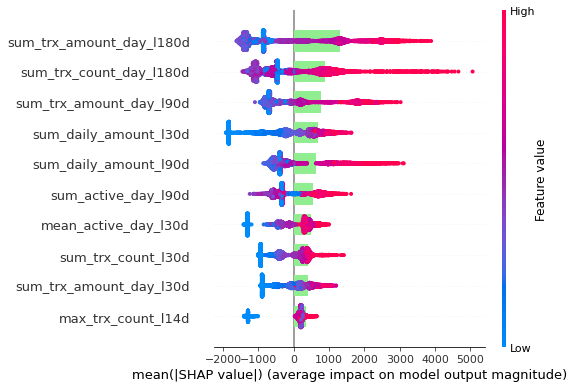

In [ ]:
features_sorted_by_shap, ft_imptance = shap_summary_plot(xgbm_opt, X_train, opt_columns, nbr_to_show=10)

<b><h3>Takeaways:</h3></b>:
* How to read:
  * y-axis is the features that are ordered in descending order according to the their power of prediction
  * More red means the value of a particular feature is higher, and vice versa for the blue
  * x-axis is how much of the feature has an impact in making a prediction

* Based on the SHAP plot above, we can conclude that most of the features are positively correlated with the target variable.
* The model picked up both **trx_amount_day_l180d** and **trx_count_day_l180d** as the top 2 important features. This means that whenever the value of both features getting higher, the model's predictive power is stronger.
* This means that users who are very active during the day for the past 6 months have strong predictive power.

## 4.3 Predicting for January 2022

In [ ]:
"""
LOAD PICKLE
"""
file_name = f"{configs['MODEL_PATH']}/xgbm_opt.pkl"
xgbm_opt = pickle.load(open(file_name, "rb"))

In [ ]:
"""
LOAD FINAL COLUMNS
"""
final_columns = pd.read_csv(f"{configs['FINAL_PATH']}/final_columns.csv")
final_columns = final_columns['final_columns'].values.tolist()
len(final_columns), final_columns[:5], final_columns[-5:]

(17,
 ['mean_trx_count_l14d',
  'sum_trx_count_l14d',
  'max_trx_count_l14d',
  'mean_active_day_l14d',
  'sum_active_day_l14d'],
 ['sum_daily_amount_l90d',
  'sum_active_day_l90d',
  'sum_trx_amount_day_l90d',
  'sum_trx_count_day_l180d',
  'sum_trx_amount_day_l180d'])

#### CREATING FEATURES FOR DECEMBER 2022

In [ ]:
"""
Building the datamart by aggregating daily amount per user for different types of transaction behavior, such as time based transaction.
"""
cutoff_monthyear_pred = str(configs['CUTOFF_DATE'].year) + str(configs['CUTOFF_DATE'].month+1).zfill(2)
print(cutoff_monthyear_pred)
daily_trx_pred = trx_raw[trx_raw['monthyear'] <= cutoff_monthyear_pred].groupby(
    ['user_id', 'trx_date'],
    as_index = False,
    observed = True
).agg(
    daily_amount = ('trx_amount', 'sum'),
    trx_count = ('trx_amount', 'size'),
    trx_count_weekend = ('is_weekend', 'sum'),
    trx_count_weekday = ('is_weekday', 'sum'),
    trx_amount_weekend = ('trx_amount_weekend', 'sum'),
    trx_amount_weekday = ('trx_amount_weekday', 'sum'),
    trx_count_day = ('trx_day', 'sum'),
    trx_count_night = ('trx_night', 'sum'),
    trx_amount_day = ('trx_amount_day', 'sum'),
    trx_amount_night = ('trx_amount_night', 'sum')
)
daily_trx_pred['active_day'] = 1
daily_trx_pred['trx_date'].min(), daily_trx_pred['trx_date'].max()

202112


('2020-01-01', '2021-12-31')

In [ ]:
suffix_timestamp(configs['CUTOFF_DATE'] + relativedelta(days=31), time_range)

{'l7d': [datetime.date(2021, 12, 24), datetime.date(2021, 12, 31)],
 'l14d': [datetime.date(2021, 12, 17), datetime.date(2021, 12, 31)],
 'l30d': [datetime.date(2021, 12, 1), datetime.date(2021, 12, 31)],
 'l90d': [datetime.date(2021, 10, 2), datetime.date(2021, 12, 31)],
 'l180d': [datetime.date(2021, 7, 4), datetime.date(2021, 12, 31)]}

In [ ]:
# test_df_users = test_df[['user_id']].drop_duplicates()
# test_df_users

agg_prefix = {
    'daily_amount': ['mean', 'sum', 'min', 'max'],
    'trx_count': ['mean', 'sum', 'max'],
    'active_day': ['mean', 'sum'],
    'trx_count_weekend': ['sum', 'max'],
    'trx_count_weekday': ['sum', 'max'],
    'trx_amount_weekend': ['sum', 'max'],
    'trx_amount_weekday': ['sum', 'max'],
    'trx_count_day': ['sum', 'max'],
    'trx_count_night': ['sum', 'max'],
    'trx_amount_day': ['sum', 'max'],
    'trx_amount_night': ['sum', 'max']
}

time_range = [
    'l7d', # Last 7 DAYS from the cutoff date
    'l14d', # Last 14 DAYS from the cutoff date
    'l30d', # Last 30 DAYS from the cutoff date
    'l90d', # Last 90 DAYS from the cutoff date
    'l180d' # Last 180 DAYS from the cutoff date
]

cutoff_date_pred = configs['CUTOFF_DATE'] + relativedelta(days=31)
suffix_daterange_map = suffix_timestamp(cutoff_date_pred, time_range)
print(suffix_daterange_map)

all_users_pred = trx_raw[['user_id']].drop_duplicates()
print(f"shape before: {all_users_pred.shape}")

for suffix, date_range in suffix_daterange_map.items():
    for agg_ix, agg_val in agg_prefix.items():
        for agg in agg_val:
            
            if agg_ix in ['trx_count', 'active_day'] and agg == 'mean':
                agg_test = daily_trx[ # test_df
                    (pd.to_datetime(daily_trx['trx_date']) <= date_range[1].strftime(DATE_FORMAT)) &
                    (pd.to_datetime(daily_trx['trx_date']) > date_range[0].strftime(DATE_FORMAT))
                ].groupby(
                    ['user_id'],
                    as_index = False,
                    observed = True
                ).agg(
                    {
                        agg_ix: 'sum'
                    }
                )
                
                agg_test[agg_ix] = agg_test[agg_ix] / int(suffix[1:-1])
            else:
                agg_test = daily_trx[ # test_df
                    (pd.to_datetime(daily_trx['trx_date']) <= date_range[1].strftime(DATE_FORMAT)) &
                    (pd.to_datetime(daily_trx['trx_date']) > date_range[0].strftime(DATE_FORMAT))
                ].groupby(
                    ['user_id'],
                    as_index = False,
                    observed = True
                ).agg(
                    {
                        agg_ix: agg
                    }
                )
            agg_test.columns = ['user_id', f'{agg}_{agg_ix}_{suffix}']
            
            all_users_pred = all_users_pred.merge(
                agg_test,
                how = 'left',
                left_on = 'user_id',
                right_on = 'user_id'
            )
            
### FIND WEEKEND WEEKDAY COLUMNS AND CALCULATE MEAN TRX AMOUNT WEEKEND WEEKDAY
all_cols = list(all_users_pred.columns) # test_df_users
r = re.compile(".*sum.*_amount_(weekday|weekend).*")
weekend_day_cols = list(filter(r.match, all_cols)) 

for i in weekend_day_cols:
    midfix_list = i.split('_')[1:-1]
    midfix = "_".join(midfix_list)
    suffix = i.split('_')[-1]
    full_col_name = f'mean_{midfix}_{suffix}'
    
    midfix_list[1] = 'count'
    denom_col_name = f'sum_{"_".join(midfix_list)}_{suffix}'
    all_users_pred[full_col_name] = all_users_pred[i] / all_users_pred[denom_col_name]

### FIND DAY AND NIGHT COLUMNS AND CALCULATE MEAN TRX AMOUNT DAY AND NIGHT
all_cols = list(all_users_pred.columns) # test_df_users
r = re.compile(".*sum.*_amount_(day|night).*")
day_night_cols = list(filter(r.match, all_cols)) 

for i in day_night_cols:
    midfix_list = i.split('_')[1:-1]
    midfix = "_".join(midfix_list)
    suffix = i.split('_')[-1]
    full_col_name = f'mean_{midfix}_{suffix}'
    
    midfix_list[1] = 'count'
    denom_col_name = f'sum_{"_".join(midfix_list)}_{suffix}'
    all_users_pred[full_col_name] = all_users_pred[i] / all_users_pred[denom_col_name]

print(f"shape after: {all_users_pred.shape}")

{'l7d': [datetime.date(2021, 12, 24), datetime.date(2021, 12, 31)], 'l14d': [datetime.date(2021, 12, 17), datetime.date(2021, 12, 31)], 'l30d': [datetime.date(2021, 12, 1), datetime.date(2021, 12, 31)], 'l90d': [datetime.date(2021, 10, 2), datetime.date(2021, 12, 31)], 'l180d': [datetime.date(2021, 7, 4), datetime.date(2021, 12, 31)]}
shape before: (9542, 1)
shape after: (9542, 146)


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [ ]:
all_users_pred = all_users_pred[['user_id'] + final_columns]
all_users_pred = all_users_pred.fillna(0)

In [ ]:
jan_pred = xgbm_opt.predict(all_users_pred[final_columns], ntree_limit=xgbm_opt.get_booster().best_ntree_limit )

In [ ]:
full_jan_pred = pd.DataFrame(
    {
        'user_id': all_users_pred['user_id'].values.tolist(),
        'jan_2022_gmv': jan_pred
    }
)

In [ ]:
print(full_jan_pred.shape)
full_jan_pred.head()

(9542, 2)


,user_id,jan_2022_gmv
0,93098549-3ff0-e579-01c3-df9183278f64,5140.732910
1,1f8a8d4e-dec8-e4da-7c8e-901e84151b73,7086.676758
2,4502d7f8-54a1-396c-e9ab-fb0d9be57401,9862.021484
3,41f5d7dc-deda-5cd0-31ce-d96df44181ec,5337.043945
4,a800c6f7-3776-b599-a70a-e3961bd01b16,3574.144775


In [ ]:
f"{configs['PREDICTION_PATH']}/users_jan_2022_prediction.csv"

'data/05.predictions/users_jan_2022_prediction.csv'

In [ ]:
full_jan_pred.to_csv(f"{configs['PREDICTION_PATH']}/users_jan_2022_prediction.csv",index = False)

# 5. Modeling For Whole Company GMV Prediction

In [66]:
DATE_FORMAT = '%Y-%m-%d'
trx_raw = pd.read_csv(f"{configs['INTERMEDIATE_PATH']}/trx_fin_raw.csv")

## 5.1 Creating dataset and quick analysis on the data

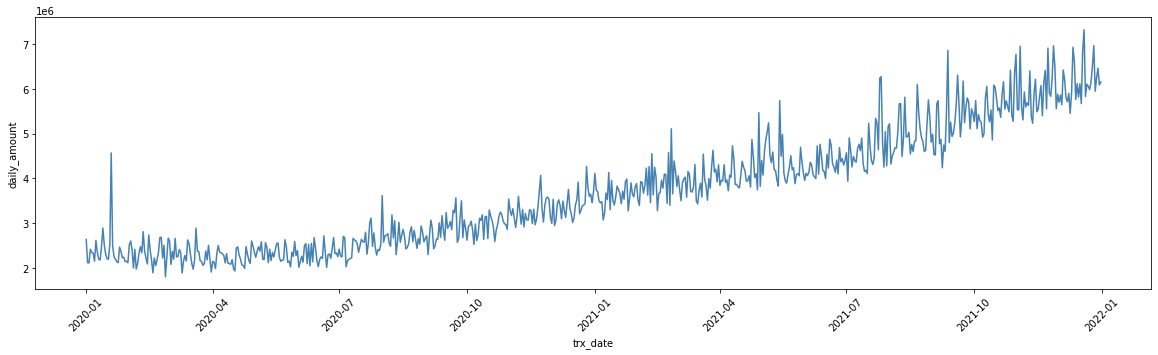

In [67]:
daily_trx = trx_raw.groupby(
    ['trx_date'],
    as_index = False,
    observed = True
).agg(
    daily_amount = ('trx_amount', 'sum')
)
daily_trx.sort_values('trx_date', ascending=True, inplace = True)
daily_trx['trx_date'] = pd.to_datetime(daily_trx['trx_date'])
daily_trx = daily_trx.set_index('trx_date')

fig = plt.figure(figsize = (20,5))
sns.lineplot(x = 'trx_date', y = 'daily_amount', data = daily_trx, color = 'steelblue')
plt.xticks(rotation=45)
plt.show()

* In general the total daily GMV increases over time with the middle of July 2020 the GMV started to grow.

In [68]:
"""
SAVE DAILY TRX TO INTERNEDIATE FOLDER
"""
daily_trx.to_csv(f"{configs['INTERMEDIATE_PATH']}/daily_trx.csv")

In [69]:
daily_trx = create_features(daily_trx)

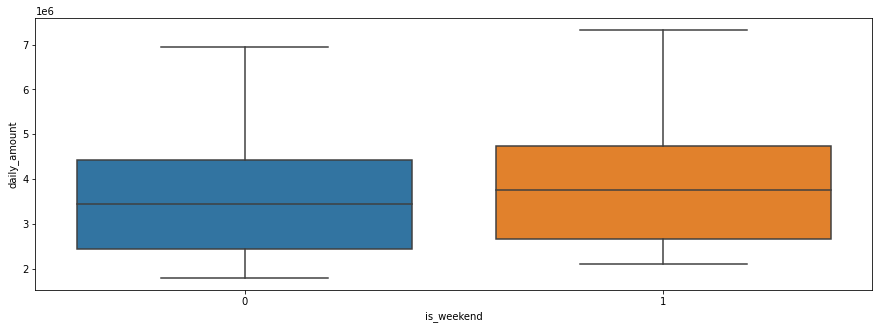

In [70]:
fig, ax = plt.subplots(figsize = (15,5))

sns.boxplot(x = 'is_weekend', y = 'daily_amount', data = daily_trx)
plt.show()

* People tend to spend on the weekends as the daily GMV on weekends are a little bit higher than transactions on weekdays

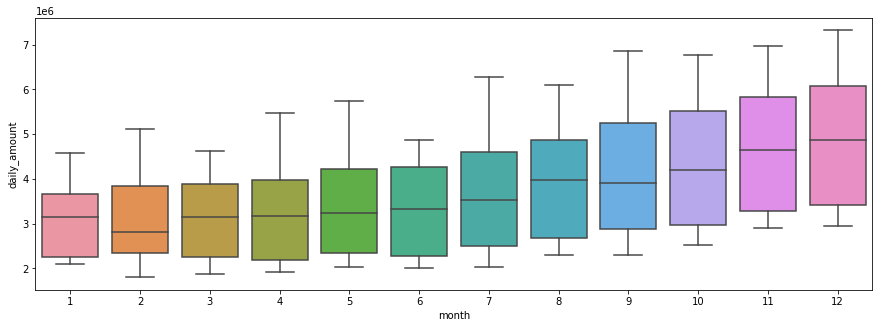

In [71]:
fig, ax = plt.subplots(figsize = (15,5))

sns.boxplot(x = 'month', y = 'daily_amount', data = daily_trx)
plt.show()

* The distribution of daily amount is increasing for each month. This could due to as the time is approaching end of the year, people spend more for the the holidays.

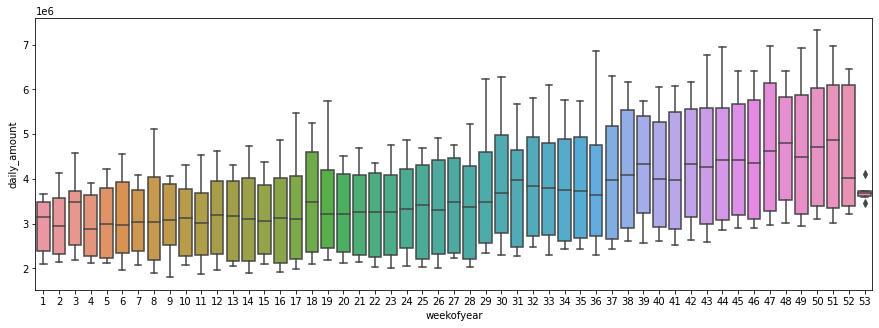

In [72]:
fig, ax = plt.subplots(figsize = (15,5))

sns.boxplot(x = 'weekofyear', y = 'daily_amount', data = daily_trx)
plt.show()

#### SPLIT THE DATA

In [73]:
train = daily_trx[daily_trx.index < "2021-12-01"]
test = daily_trx[daily_trx.index >= "2021-12-01"]

train['weekofyear'] = train['weekofyear'].astype(int)
test['weekofyear'] = test['weekofyear'].astype(int)

In [74]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 700 entries, 2020-01-01 to 2021-11-30
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   daily_amount  700 non-null    int64
 1   month         700 non-null    int64
 2   year          700 non-null    int64
 3   dayofweek     700 non-null    int64
 4   quarter       700 non-null    int64
 5   dayofyear     700 non-null    int64
 6   weekofyear    700 non-null    int64
 7   is_weekend    700 non-null    int64
dtypes: int64(8)
memory usage: 49.2 KB


## 5.2 Start modeling with simple features

In [75]:
FEATURE_COLS = list(train.drop(['daily_amount'],axis = 1).columns)
TARGET_COL = 'daily_amount'

In [76]:
X_train = train[FEATURE_COLS]
y_train = train[TARGET_COL]
X_test = test[FEATURE_COLS]
y_test = test[TARGET_COL]

In [77]:
xgbm_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators = 10000,
    max_depth = 5,
    learning_rate = 0.01,
    gamma = 3,
    # reg_alpha = 2,
    reg_lambda = 5,
    min_child_weight = 5,
    subsample = 0.5,
    # max_delta_step = 1,
    # colsample_bytree = 0.4,
    # colsample_bylevel = 0.5,
    eval_metric = ['rmse'],
    early_stopping_rounds = 200,
    seed = 1234
)

xgbm_reg.fit(
    X_train, 
    y_train, 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose = 200
)

train_pred = xgbm_reg.predict(X_train, iteration_range=(0, xgbm_reg.best_iteration))
test_pred = xgbm_reg.predict(X_test, iteration_range=(0, xgbm_reg.best_iteration))
# evaluate predictions
train_rmse = mean_squared_error(y_train, train_pred, squared=False)
test_rmse = mean_squared_error(y_test, test_pred, squared=False)

print(f"""
  Train RMSE: {train_rmse}
  Test RMSE: {test_rmse}
""")

[0]	validation_0-rmse:3737597.01582	validation_1-rmse:6106692.64603
[200]	validation_0-rmse:672071.13385	validation_1-rmse:1559499.32006
[400]	validation_0-rmse:306802.52927	validation_1-rmse:657764.99801
[600]	validation_0-rmse:263865.21217	validation_1-rmse:429466.70165
[800]	validation_0-rmse:247763.55042	validation_1-rmse:357532.31241
[1000]	validation_0-rmse:237430.41592	validation_1-rmse:324236.26628
[1200]	validation_0-rmse:228568.74597	validation_1-rmse:309996.93297
[1400]	validation_0-rmse:221042.14794	validation_1-rmse:298551.18737
[1600]	validation_0-rmse:214729.90008	validation_1-rmse:291428.29229
[1800]	validation_0-rmse:208645.22125	validation_1-rmse:284686.32564
[2000]	validation_0-rmse:203226.68289	validation_1-rmse:278551.67854
[2200]	validation_0-rmse:198232.30669	validation_1-rmse:279003.21517
[2400]	validation_0-rmse:193377.76516	validation_1-rmse:274419.42897
[2600]	validation_0-rmse:188886.62709	validation_1-rmse:274236.25449
[2601]	validation_0-rmse:188871.39555	

In [78]:
"""
SAVE MODEL
"""
file_name = f"{configs['MODEL_PATH']}/xgbm_daily_v1.pkl"

# save
pickle.dump(xgbm_reg, open(file_name, "wb"))

First Iteration:
* Train RMSE = 193,355.8
* Test RMSE = 274,393.8
* Both RMSE are big. So we can try to improve it by adding more features to the model and do cross validation.

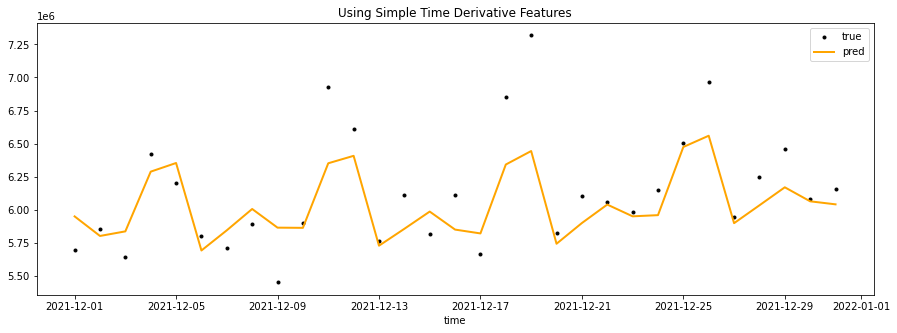

In [90]:
plt.figure(figsize=(15,5))
plt.plot(X_test.index, y_test, '.k', label='true')
plt.plot(X_test.index, test_pred, 'orange', linewidth=2, label='pred')
plt.title('Using Simple Time Derivative Features'); plt.xlabel('time'); 
plt.legend()
plt.show()

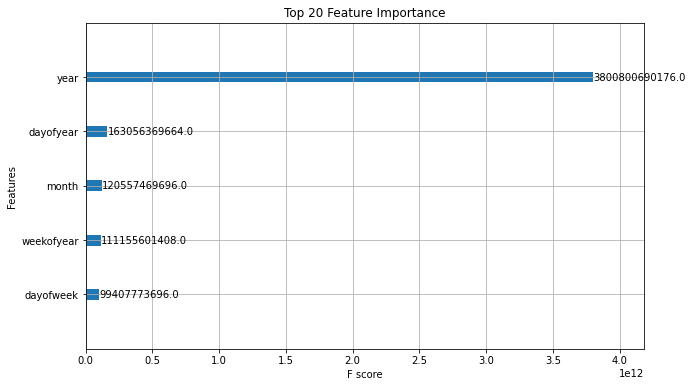

In [79]:
fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(xgbm_reg, importance_type = 'gain', max_num_features=20, title='Top 20 Feature Importance', ax = ax)
plt.show()

## 5.3 Model Improvement

In [6]:
daily_trx = pd.read_csv(f"{configs['INTERMEDIATE_PATH']}/daily_trx.csv")
daily_trx = daily_trx.set_index('trx_date')
daily_trx.index = pd.to_datetime(daily_trx.index)
daily_trx = daily_trx.sort_index()

### Check Outlier

In [7]:
daily_trx.daily_amount.describe()

count    7.310000e+02
mean     3.688144e+06
std      1.280656e+06
min      1.799311e+06
25%      2.538274e+06
50%      3.517896e+06
75%      4.559038e+06
max      7.318152e+06
Name: daily_amount, dtype: float64

In [8]:
Q1 = daily_trx['daily_amount'].quantile(0.25)
Q3 = daily_trx['daily_amount'].quantile(0.75)
IQR = Q3 - Q1
S = 1.5*IQR
LB = Q1 - S
UB = Q3 + S
LB, UB

(-492874.0, 7590186.0)

Since Max value of daily amout is still within the Upper Boundary, that means there is no outliers that need to be treated.

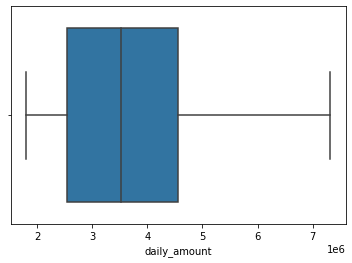

In [9]:
sns.boxplot(x='daily_amount', data = daily_trx)
plt.show()

### Check on Fold

In [92]:
"""
test_size = 31 means predict for the next 31 days
"""
tss = TimeSeriesSplit(n_splits = 5, test_size = 31) 

In [93]:
new_daily_trx = daily_trx.sort_index()

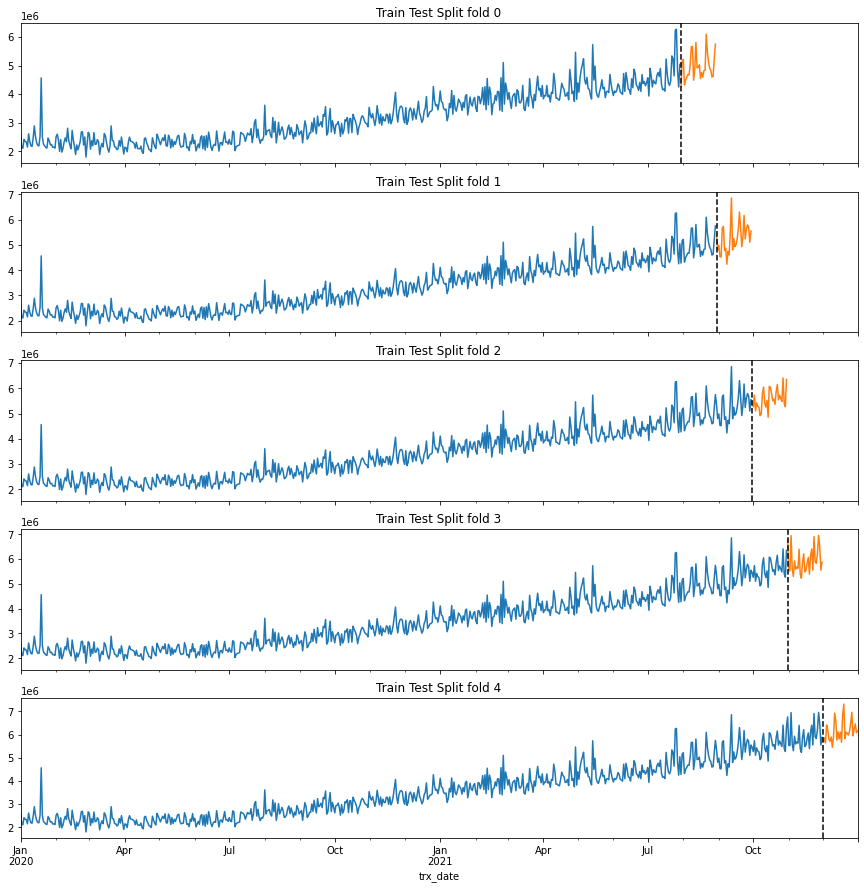

In [15]:
fig, ax = plt.subplots(5, 1, figsize = (15,15), sharex = True)

fold = 0
for train_ix, val_ix in tss.split(new_daily_trx):
    train = new_daily_trx.iloc[train_ix]
    test = new_daily_trx.iloc[val_ix]

    ## PLOT
    train['daily_amount'].plot(ax=ax[fold], title=f"Train Test Split fold {fold}", label="Train Dataset")
    test['daily_amount'].plot(ax=ax[fold], label="Train Dataset")
    ax[fold].axvline(test.index.min(), color = 'black', ls = '--')

    fold += 1

### Add more features

In [94]:
new_daily_trx = create_features(new_daily_trx)

In [95]:
new_daily_trx = add_lags(new_daily_trx, 'daily_amount')

In [97]:
new_daily_trx.tail()

,daily_amount,month,year,dayofweek,quarter,dayofyear,weekofyear,is_weekend,ft_lag_31,ft_lag_62,ft_lag_93,ft_lag_124,ft_lag_155,ft_lag_186,ft_lag_217,ft_lag_248,ft_lag_279,ft_lag_310,ft_lag_341,ft_lag_372
trx_date,,,,,,,,,,,,,,,,,,,,
2021-12-27,5944091,12,2021,0,4,361,52,0,6217323.0,5485038.0,5597962.0,4822156.0,6239606.0,4408346.0,4236252.0,3805244.0,3511175.0,4096481.0,3432149.0,3915613.0
2021-12-28,6245729,12,2021,1,4,362,52,0,6959008.0,6411889.0,5796086.0,4598071.0,6270211.0,4097423.0,3879729.0,4866048.0,3994362.0,4085637.0,3711484.0,3208559.0
2021-12-29,6462267,12,2021,2,4,363,52,0,6484910.0,5405381.0,5698373.0,4623032.0,4801130.0,4687535.0,4085981.0,4497317.0,3780616.0,3440333.0,3533003.0,3286846.0
2021-12-30,6083073,12,2021,3,4,364,52,0,5555213.0,5272068.0,5104268.0,5228121.0,4251324.0,4370271.0,4102307.0,4020588.0,4264390.0,4575734.0,3929447.0,3385672.0
2021-12-31,6153751,12,2021,4,4,365,52,0,5879122.0,6352360.0,5552970.0,5751634.0,5044302.0,4440048.0,4055859.0,4099760.0,4626432.0,3397351.0,3982859.0,3400645.0


### Train without splits

In [98]:
train = new_daily_trx[new_daily_trx.index < "2021-12-01"]
test = new_daily_trx[new_daily_trx.index >= "2021-12-01"]

In [108]:
FEATURE_COLS = list(train.drop(['daily_amount'],axis = 1).columns)
TARGET_COL = 'daily_amount'

X_train = train[FEATURE_COLS]
y_train = train[TARGET_COL]
X_test = test[FEATURE_COLS]
y_test = test[TARGET_COL]

xgbm_add_ft_no_split = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators = 10000,
    max_depth = 3,
    learning_rate = 0.01,
    gamma = 5,
    # reg_alpha = 2,
#     reg_lambda = 5,
    min_child_weight = 5,
    subsample = 0.5,
    # max_delta_step = 1,
    # colsample_bytree = 0.4,
    colsample_bylevel = 0.5,
    eval_metric = ['rmse'],
    early_stopping_rounds = 500,
    seed = 1234
)

xgbm_add_ft_no_split.fit(
    X_train, 
    y_train, 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose = 200
)

"""
SAVE MODEL
"""
file_name = f"{configs['MODEL_PATH']}/xgbm_daily_v2_no_split.pkl"
# save
pickle.dump(xgbm_add_ft_no_split, open(file_name, "wb"))

train_pred = xgbm_add_ft_no_split.predict(X_train, iteration_range=(0, xgbm_add_ft_no_split.best_iteration))
test_pred = xgbm_add_ft_no_split.predict(X_test, iteration_range=(0, xgbm_add_ft_no_split.best_iteration))
# evaluate predictions
train_rmse = mean_squared_error(y_train, train_pred, squared=False)
test_rmse = mean_squared_error(y_test, test_pred, squared=False)

print(f"""
  Train RMSE: {train_rmse}
  Test RMSE: {test_rmse}
""")

[0]	validation_0-rmse:3736466.28400	validation_1-rmse:6099981.08369
[200]	validation_0-rmse:606354.45708	validation_1-rmse:1273991.75794
[400]	validation_0-rmse:284188.77800	validation_1-rmse:496140.67035
[600]	validation_0-rmse:252006.10809	validation_1-rmse:355730.44595
[800]	validation_0-rmse:235655.28831	validation_1-rmse:337726.76424
[1000]	validation_0-rmse:222806.90626	validation_1-rmse:332284.31420
[1200]	validation_0-rmse:211231.29340	validation_1-rmse:334405.03909
[1381]	validation_0-rmse:201959.55730	validation_1-rmse:332393.74280

  Train RMSE: 230258.18995592985
  Test RMSE: 329661.7634712766



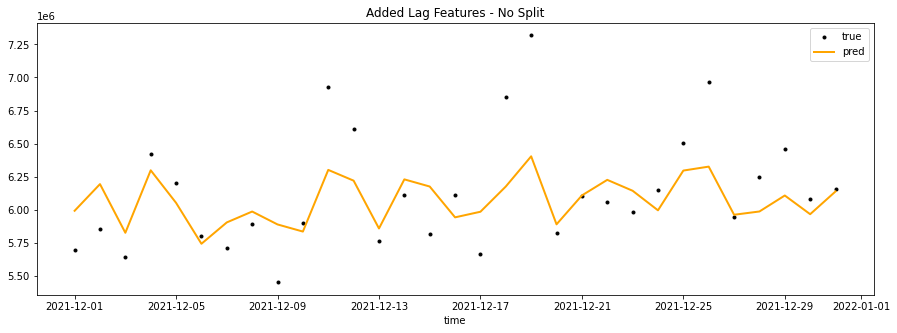

In [109]:
plt.figure(figsize=(15,5))
plt.plot(X_test.index, y_test, '.k', label='true')
plt.plot(X_test.index, test_pred, 'orange', linewidth=2, label='pred')
plt.title('Added Lag Features - No Split'); plt.xlabel('time'); 
plt.legend()
plt.show()

### Train using Moving Window

In [177]:
start_date = datetime.date(2020,1,1)

date_pd = {
    'train_date_start': [],
    'train_date_end': [],
    'test_date_start': [],
    'test_date_end': []
}
day_range = 60
for i in range(100):
    if start_date + relativedelta(days=day_range+1+30) > datetime.date(2021,12,31):
        break
        
    train_date_start = start_date
    train_date_end = start_date + relativedelta(days=day_range)
    test_date_start = train_date_end + relativedelta(days=1)
    test_date_end = test_date_start + relativedelta(days=30)
    
    date_pd['train_date_start'].append(train_date_start)
    date_pd['train_date_end'].append(train_date_end)
    date_pd['test_date_start'].append(test_date_start)
    date_pd['test_date_end'].append(test_date_end)
    
    start_date = test_date_end + relativedelta(days=1)

In [178]:
pd.DataFrame(date_pd)

,train_date_start,train_date_end,test_date_start,test_date_end
0,2020-01-01,2020-03-01,2020-03-02,2020-04-01
1,2020-04-02,2020-06-01,2020-06-02,2020-07-02
2,2020-07-03,2020-09-01,2020-09-02,2020-10-02
3,2020-10-03,2020-12-02,2020-12-03,2021-01-02
4,2021-01-03,2021-03-04,2021-03-05,2021-04-04
5,2021-04-05,2021-06-04,2021-06-05,2021-07-05
6,2021-07-06,2021-09-04,2021-09-05,2021-10-05


In [182]:
tss = TimeSeriesSplit(n_splits = 20, test_size = 31, gap = 0) 
new_daily_trx = daily_trx[['daily_amount']].sort_index()

scores = {
    'fold': [],
    'train_scores': [],
    'test_scores': []
}

fold = 0


# for train_ix, val_ix in tss.split(new_daily_trx):
for ix, val in enumerate(range(pd.DataFrame(date_pd).shape[0])):
#     train = new_daily_trx.iloc[train_ix]
#     test = new_daily_trx.iloc[val_ix]
    train = new_daily_trx[
        (new_daily_trx.index >= date_pd['train_date_start'][ix].strftime(DATE_FORMAT)) &
        (new_daily_trx.index <= date_pd['train_date_end'][ix].strftime(DATE_FORMAT))
    ]
    
    test = new_daily_trx[
        (new_daily_trx.index >= date_pd['test_date_start'][ix].strftime(DATE_FORMAT)) &
        (new_daily_trx.index <= date_pd['test_date_end'][ix].strftime(DATE_FORMAT))
    ]
    
    print('TRAIN', train.index.min(), train.index.max())
    print('TEST', test.index.min(), test.index.max())
    
    train = create_features(train)
    test = create_features(test)

    train = add_lags(train, 'daily_amount')
    test = add_lags(test, 'daily_amount')
    
    train = train.fillna(0)
    test = test.fillna(0)

    FEATURE_COLS = list(train.drop(['daily_amount'], axis = 1).columns)
    TARGET_COL = 'daily_amount'

    X_train = train[FEATURE_COLS]
    y_train = train[TARGET_COL]

    X_test = test[FEATURE_COLS]
    y_test = test[TARGET_COL]

    xgbm_imp = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators = 10000,
        max_depth = 3,
        learning_rate = 0.01,
        gamma = 5,
        # reg_alpha = 2,
    #     reg_lambda = 5,
        min_child_weight = 5,
        subsample = 0.5,
        # max_delta_step = 1,
        # colsample_bytree = 0.4,
        colsample_bylevel = 0.5,
        eval_metric = ['rmse'],
        early_stopping_rounds = 500,
        seed = 1234
    )

    xgbm_imp.fit(
        X_train, 
        y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)], 
        verbose = 200
    )

    train_pred = xgbm_imp.predict(X_train, iteration_range=(0, xgbm_imp.best_iteration))
    test_pred = xgbm_imp.predict(X_test, iteration_range=(0, xgbm_imp.best_iteration)) ## , ntree_limit=xgbm_imp.get_booster().best_ntree_limit
    # evaluate predictions
    train_rmse = mean_squared_error(y_train, train_pred, squared=False)
    test_rmse = mean_squared_error(y_test, test_pred, squared=False)

    scores['fold'].append(fold)
    scores['train_scores'].append(train_rmse)
    scores['test_scores'].append(test_rmse)

    fold += 1

scores = pd.DataFrame(scores)

TRAIN 2020-01-01 00:00:00 2020-03-01 00:00:00
TEST 2020-03-02 00:00:00 2020-04-01 00:00:00
[0]	validation_0-rmse:2366511.90225	validation_1-rmse:2249804.72878
[200]	validation_0-rmse:477321.84968	validation_1-rmse:323431.44761
[400]	validation_0-rmse:297466.85777	validation_1-rmse:238689.30585
[600]	validation_0-rmse:271479.83916	validation_1-rmse:282124.58977
[800]	validation_0-rmse:256971.27820	validation_1-rmse:298461.59813
[815]	validation_0-rmse:256052.07116	validation_1-rmse:299887.26665
TRAIN 2020-04-02 00:00:00 2020-06-01 00:00:00
TEST 2020-06-02 00:00:00 2020-07-02 00:00:00
[0]	validation_0-rmse:2267457.60451	validation_1-rmse:2292211.60272
[200]	validation_0-rmse:368382.66605	validation_1-rmse:388618.27320
[400]	validation_0-rmse:144238.78802	validation_1-rmse:177092.20965
[600]	validation_0-rmse:119014.26816	validation_1-rmse:166712.60851
[800]	validation_0-rmse:109301.77349	validation_1-rmse:167650.49258
[1000]	validation_0-rmse:102750.81032	validation_1-rmse:165437.00420
[

In [187]:
"""
SAVE MODEL
"""
file_name = f"{configs['MODEL_PATH']}/xgbm_daily_v2_split.pkl"

# save
pickle.dump(xgbm_imp, open(file_name, "wb"))

In [183]:
scores

,fold,train_scores,test_scores
0,0,329031.613003,215758.999762
1,1,92910.337703,161740.414244
2,2,182817.015632,369707.378735
3,3,162630.092467,341151.934527
4,4,243716.036343,260581.116620
5,5,217062.215169,220168.062232
6,6,317896.221720,665151.794077


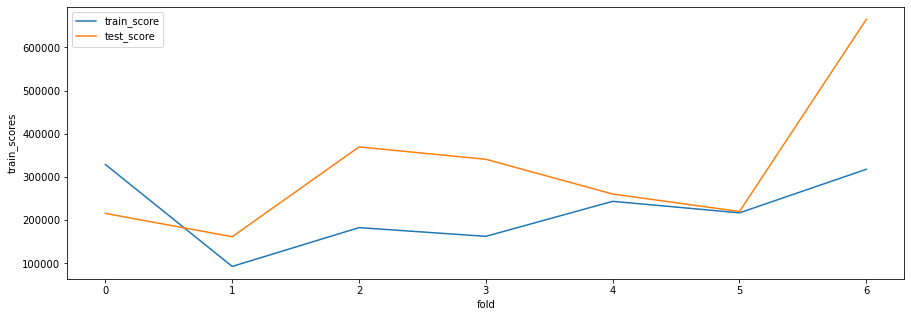

In [184]:
fig, ax = plt.subplots(figsize=(15,5))

sns.lineplot(x = 'fold', y='train_scores', data = scores, label = 'train_score')
sns.lineplot(x = 'fold', y='test_scores', data = scores, label = 'test_score')

# ax.set_xticklabels(scores['fold'].values.tolist())
plt.legend()
plt.show()

In [185]:
print(
    f"""
    Average Train Score: {np.mean(scores['train_scores'])},
    Average Test Score: {np.mean(scores['test_scores'])}
    """
)


    Average Train Score: 220866.21886249268,
    Average Test Score: 319179.9571710353
    


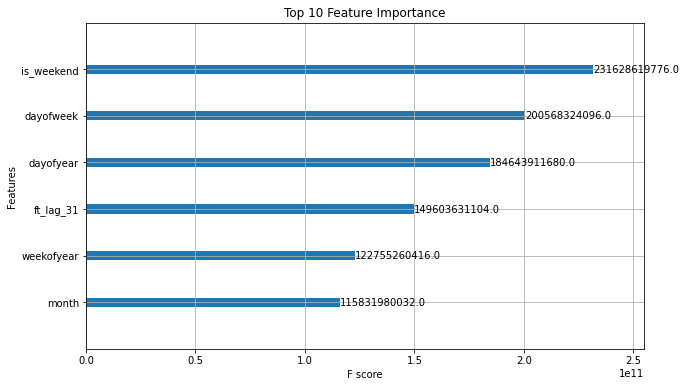

In [193]:
fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(xgbm_imp, importance_type = 'gain', max_num_features=10, title='Top 10 Feature Importance', ax = ax)
plt.show()

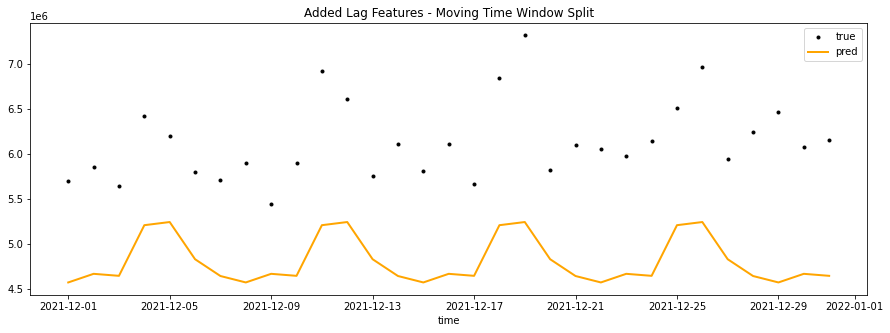

In [192]:
pred_data = new_daily_trx[new_daily_trx.index >= '2021-12-01']
pred_data = create_features(pred_data)
pred_data = add_lags(pred_data, 'daily_amount')

FEATURE_COLS = list(pred_data.drop(['daily_amount'], axis = 1).columns)
TARGET_COL = 'daily_amount'

pred_on_dec = xgbm_imp.predict(pred_data[FEATURE_COLS], iteration_range=(0, xgbm_imp.best_iteration))

plt.figure(figsize=(15,5))
plt.plot(pred_data.index, pred_data[TARGET_COL], '.k', label='true')
plt.plot(pred_data.index, pred_on_dec, 'orange', linewidth=2, label='pred')
plt.title('Added Lag Features - Moving Time Window Split'); plt.xlabel('time'); 
plt.legend()
plt.show()

## 5.4 Model Improvement with Time Series Forecasting Library

In [10]:
daily_trx = daily_trx.sort_index()
daily_trx.head()

,daily_amount
trx_date,
2020-01-01,2633813
2020-01-02,2115625
2020-01-03,2110395
2020-01-04,2415564
2020-01-05,2346069


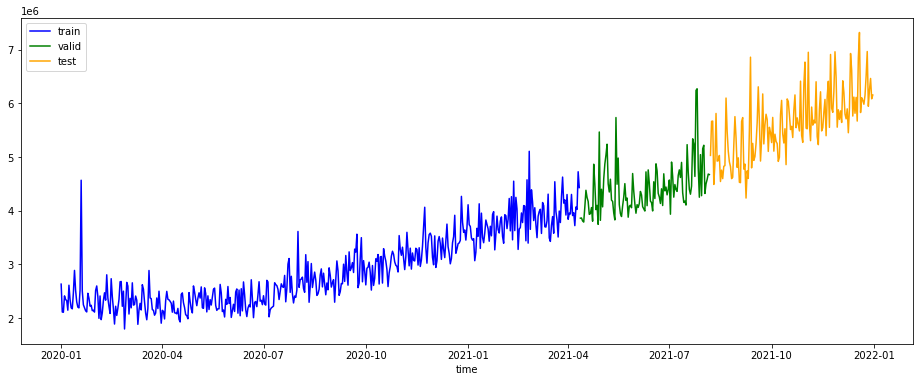

In [54]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    daily_trx.index, daily_trx['daily_amount'], test_size=0.2, shuffle=False
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, shuffle=False
)

plt.figure(figsize=(16,6))
plt.plot(X_train, y_train, c='blue', label='train')
plt.plot(X_val, y_val, c='green', label='valid')
plt.plot(X_test, y_test, c='orange', label='test')
plt.xlabel('time'); plt.legend(); plt.show()


    TRAIN RMSE: 4364236.61
    VAL RMSE: 1020427.23
    TEST RMSE: 460689.97



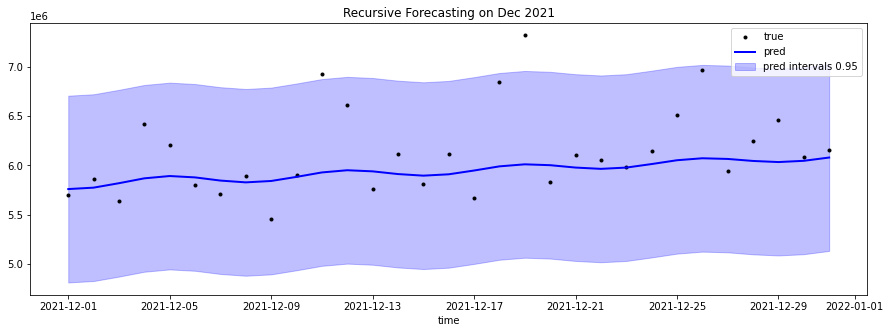

In [63]:
### CONFORMAL PREDICTION WITH RECURSIVE FORECASTING ###

forecaster = ForecastingCascade(
    Ridge(),
    lags=range(1,32),
    use_exog=False,
)

forecaster.fit(None, y_train)
y_pred_val_rec = forecaster.predict(X_val)

model = MapieRegressor(
    forecaster, cv="prefit"
).fit(X_val, y_val)

forecaster.fit(None, y_train_val)
model.single_estimator_ = forecaster

"""
SAVE MODEL
"""
file_name = f"{configs['MODEL_PATH']}/recursive_forecasting.pkl"

# save
pickle.dump(model, open(file_name, "wb"))

### EVALUATE ###
y_pred_train_rec = model.predict(X_train, alpha=0.05)
y_pred_val_rec = model.predict(X_val, alpha=0.05)
y_pred_test_rec = model.predict(X_test, alpha=0.05)

train_rmse = mean_squared_error(y_train, y_pred_train_rec[0], squared=False)
val_rmse = mean_squared_error(y_val, y_pred_val_rec[0], squared=False)
test_rmse = mean_squared_error(y_test, y_pred_test_rec[0], squared=False)

print(f"""
    TRAIN RMSE: {train_rmse:.02f}
    VAL RMSE: {val_rmse:.02f}
    TEST RMSE: {test_rmse:.02f}
""")

plt.figure(figsize=(15,5))
plt.plot(X_test[-31:], y_test[-31:], '.k', label='true')
plt.fill_between(X_test[-31:], y_pred_test_rec[1][-31:, 0, 0], y_pred_test_rec[1][-31:, 1, 0], 
                 alpha=0.25, color='blue', label='pred intervals 0.95')
plt.plot(X_test[-31:], y_pred_test_rec[0][-31:], 'blue', linewidth=2, label='pred')
plt.title('Recursive Forecasting on Dec 2021'); plt.xlabel('time'); plt.legend()
plt.show()


    TRAIN RMSE: 3530251.98
    VAL RMSE: 999128.47
    TEST RMSE: 504342.12



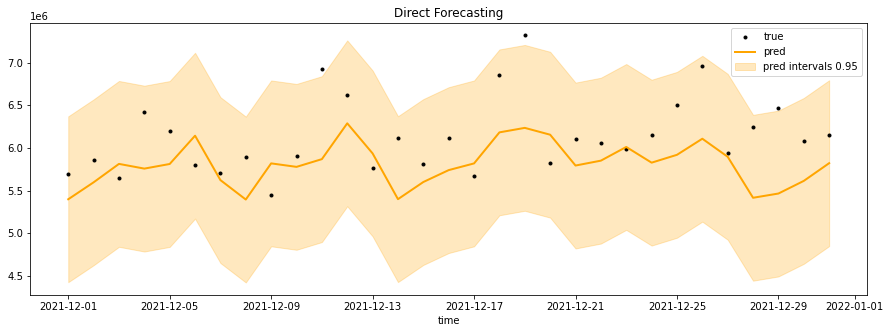

In [62]:
### CONFORMAL PREDICTION WITH DIRECT FORECASTING ###

forecaster = ForecastingChain(
    Ridge(),
    n_estimators=len(y_test),
    lags=range(1,32),
    use_exog=False
)

forecaster.fit(None, y_train)
y_pred_val_dir = forecaster.predict(X_val)

model = MapieRegressor(
    forecaster, cv="prefit"
).fit(X_val, y_val)

forecaster.fit(None, y_train_val)
model.single_estimator_ = forecaster

"""
SAVE MODEL
"""
file_name = f"{configs['MODEL_PATH']}/direct_forecasting.pkl"

# save
pickle.dump(model, open(file_name, "wb"))

### EVALUATE ###
y_pred_train_dir = model.predict(X_train, alpha=0.05)
y_pred_val_dir = model.predict(X_val, alpha=0.05)
y_pred_test_dir = model.predict(X_test, alpha=0.05)

train_rmse = mean_squared_error(y_train, y_pred_train_dir[0], squared=False)
val_rmse = mean_squared_error(y_val, y_pred_val_dir[0], squared=False)
test_rmse = mean_squared_error(y_test, y_pred_test_dir[0], squared=False)

print(f"""
    TRAIN RMSE: {train_rmse:.02f}
    VAL RMSE: {val_rmse:.02f}
    TEST RMSE: {test_rmse:.02f}
""")


plt.figure(figsize=(15,5))
plt.plot(X_test[-31:], y_test[-31:], '.k', label='true')
plt.fill_between(X_test[-31:], y_pred_test_dir[1][-31:, 0, 0], y_pred_test_dir[1][-31:, 1, 0], 
                 alpha=0.25, color='orange', label='pred intervals 0.95')
plt.plot(X_test[-31:], y_pred_test_dir[0][-31:], 'orange', linewidth=2, label='pred')
plt.title('Direct Forecasting'); plt.xlabel('time'); plt.legend()
plt.show()

<b><h3>Model Comparison Summary:</h3></b>

| Model Version | Train Score | Validation Score | Test Score |
| --- | --- | --- | --- |
| Simple Time Derivative Features (V1) | 193,355.8 | NaN | 274,393.8 |
| Added Lags Features (V2 No Split) | 230,258.1 | NaN | 329,661.7 |
| Added Lags Features (V2 Split) | 220,866.2 | NaN | 319,179.9 |
| Recursive Forecasting | 4,364,236.61 | 1,020,427.23 | 460,689.97 |
| Direct Forecasting | 3,530,251.98 | 999,128.47 | 504,342.12 | 
  
* Direct Forecasting has more complexity while Recursive Forecasting model is too simple
* Although Direct Forecasting produced higher test score than Recursive Forecasting, but it was less overfit than the Recursive Forecasting
* Out of 4 built models, the model built using the simple time derivative features was the least overfit.
* Although **V2 Split** model still overfits, it at least has improved seen from the lower train and test scores compared to **V2 No Split**

<b><h3>Conclusion:</h3></b> We are going to user **V2 Split** as our final model for prediction on January 2022 data.

## 5.4 Prediction

In [194]:
"""
LOAD daily_trx and model
"""
new_daily_trx = pd.read_csv(f"{configs['INTERMEDIATE_PATH']}/daily_trx.csv", index_col='trx_date')
new_daily_trx.index = pd.to_datetime(new_daily_trx.index)
new_daily_trx = new_daily_trx.sort_index()

file_name = f"{configs['MODEL_PATH']}/xgbm_daily_v2_split.pkl"
final_model = pickle.load(open(file_name, "rb"))

In [195]:
future = pd.date_range('2022-01-01', '2022-01-31')
future_df = pd.DataFrame(index = future)
future_df['is_future'] = True
new_daily_trx['is_future'] = False

hist_and_future = pd.concat([new_daily_trx, future_df])
hist_and_future = create_features(hist_and_future)
hist_and_future = add_lags(hist_and_future, 'daily_amount')

In [196]:
hist_and_future.tail()

,daily_amount,is_future,month,year,dayofweek,quarter,dayofyear,weekofyear,is_weekend,ft_lag_31,...,ft_lag_93,ft_lag_124,ft_lag_155,ft_lag_186,ft_lag_217,ft_lag_248,ft_lag_279,ft_lag_310,ft_lag_341,ft_lag_372
2022-01-27,NaN,True,1,2022,3,1,27,4,0,5944091.0,...,5485038.0,5597962.0,4822156.0,6239606.0,4408346.0,4236252.0,3805244.0,3511175.0,4096481.0,3432149.0
2022-01-28,NaN,True,1,2022,4,1,28,4,0,6245729.0,...,6411889.0,5796086.0,4598071.0,6270211.0,4097423.0,3879729.0,4866048.0,3994362.0,4085637.0,3711484.0
2022-01-29,NaN,True,1,2022,5,1,29,4,1,6462267.0,...,5405381.0,5698373.0,4623032.0,4801130.0,4687535.0,4085981.0,4497317.0,3780616.0,3440333.0,3533003.0
2022-01-30,NaN,True,1,2022,6,1,30,4,1,6083073.0,...,5272068.0,5104268.0,5228121.0,4251324.0,4370271.0,4102307.0,4020588.0,4264390.0,4575734.0,3929447.0
2022-01-31,NaN,True,1,2022,0,1,31,5,0,6153751.0,...,6352360.0,5552970.0,5751634.0,5044302.0,4440048.0,4055859.0,4099760.0,4626432.0,3397351.0,3982859.0


In [197]:
futures_only = hist_and_future[hist_and_future['is_future'] == True]

In [198]:
print(futures_only.shape)
futures_only.head()

(31, 21)


,daily_amount,is_future,month,year,dayofweek,quarter,dayofyear,weekofyear,is_weekend,ft_lag_31,...,ft_lag_93,ft_lag_124,ft_lag_155,ft_lag_186,ft_lag_217,ft_lag_248,ft_lag_279,ft_lag_310,ft_lag_341,ft_lag_372
2022-01-01,NaN,True,1,2022,5,1,1,52,1,5699384.0,...,5454223.0,5361230.0,4279932.0,4295748.0,4692767.0,3746305.0,4142410.0,5106326.0,3271536.0,3447942.0
2022-01-02,NaN,True,1,2022,6,1,2,52,1,5858878.0,...,5269000.0,4806840.0,5155196.0,4398066.0,4364608.0,5465698.0,4203010.0,3653516.0,3565046.0,4267562.0
2022-01-03,NaN,True,1,2022,0,1,3,1,0,5642807.0,...,5737172.0,4984724.0,5218813.0,4572156.0,4127443.0,3821276.0,3919739.0,4389034.0,3899875.0,3789849.0
2022-01-04,NaN,True,1,2022,1,1,4,1,0,6418329.0,...,5109116.0,4530066.0,4320924.0,3935332.0,3953728.0,4399729.0,4302181.0,4160273.0,3649588.0,3598251.0
2022-01-05,NaN,True,1,2022,2,1,5,1,0,6203074.0,...,5424723.0,4522859.0,4500197.0,4905915.0,4112863.0,4071951.0,3841102.0,3817500.0,3585275.0,3641389.0


In [202]:
FEATURE_COLS = list(futures_only.drop(['daily_amount', 'is_future'], axis = 1).columns)
pred_future = final_model.predict(futures_only[FEATURE_COLS], iteration_range=(0, final_model.best_iteration))

In [204]:
futures_only['daily_amount'] = pred_future

In [205]:
futures_only.head()

,daily_amount,is_future,month,year,dayofweek,quarter,dayofyear,weekofyear,is_weekend,ft_lag_31,...,ft_lag_93,ft_lag_124,ft_lag_155,ft_lag_186,ft_lag_217,ft_lag_248,ft_lag_279,ft_lag_310,ft_lag_341,ft_lag_372
2022-01-01,5055315.0,True,1,2022,5,1,1,52,1,5699384.0,...,5454223.0,5361230.0,4279932.0,4295748.0,4692767.0,3746305.0,4142410.0,5106326.0,3271536.0,3447942.0
2022-01-02,5086752.5,True,1,2022,6,1,2,52,1,5858878.0,...,5269000.0,4806840.0,5155196.0,4398066.0,4364608.0,5465698.0,4203010.0,3653516.0,3565046.0,4267562.0
2022-01-03,4700278.0,True,1,2022,0,1,3,1,0,5642807.0,...,5737172.0,4984724.0,5218813.0,4572156.0,4127443.0,3821276.0,3919739.0,4389034.0,3899875.0,3789849.0
2022-01-04,4537053.5,True,1,2022,1,1,4,1,0,6418329.0,...,5109116.0,4530066.0,4320924.0,3935332.0,3953728.0,4399729.0,4302181.0,4160273.0,3649588.0,3598251.0
2022-01-05,4483532.0,True,1,2022,2,1,5,1,0,6203074.0,...,5424723.0,4522859.0,4500197.0,4905915.0,4112863.0,4071951.0,3841102.0,3817500.0,3585275.0,3641389.0


In [208]:
to_submit = futures_only[['daily_amount']].reset_index().rename(columns = {'index':'date'})
to_submit.to_csv(f"{configs['PREDICTION_PATH']}/jan_2022_daily_prediction.csv", index = False)